In [ ]:
!pip install git+https://github.com/tensorflow/docs
!pip install shap
import shap
from matplotlib import pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import math
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Input, LeakyReLU, ReLU, BatchNormalization
import tensorflow.keras as keras


from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import warnings
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.utils import resample
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from sklearn.linear_model import LogisticRegression



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection

SEED = 217

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ji27zc4_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ji27zc4_
  Resolved https://github.com/tensorflow/docs to commit 1c718fc8d22038e54f946627a40a01bcea48071f
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183623 sha256=9c1fabf197052fd7003c62386dea1db83c1f02cc8762c63ee03ceea5f238cbac
  Stored in directory: /tmp/pip-ephem-wheel-cache-aa5_a7p4/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 30.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
def print_scores(prediction, actual):
    """
    Prints 4 measures of model performance: F1, accuracy, precision, and recall

    Parameters:
    -----------
    prediction : predicted outcome of model
    actual : actual outcome

    Returns:
    --------
    None
    """

    print(f"- f1: {f1_score(actual, prediction)}")
    print(f"- accuracy: {accuracy_score(actual, prediction)}")
    print(f"- precision: {precision_score(actual, prediction)}")
    print(f"- recall: {recall_score(actual, prediction)}")

In [ ]:
data_ = pd.read_csv('https://raw.githubusercontent.com/zulanegus/Political-Economy/main/final_data_tar_.csv')
data_['reg_type'] = 1 - data_['reg_type']

my_data = data_.copy()

# 1. Group the data by 'country'
grouped_data = my_data.groupby('country', group_keys=False)

# 2. Identify a column labeled 'startdated' and convert it to date format
my_data['startdated'] = pd.to_datetime(my_data['startdated'], format='%d/%m/%Y')

#
def calculate_variables(group):
    group = group.sort_values('startdated')
    group['log_past_12mo_protests'] = 0
    group['log_cum_participants'] = 0

    for index, row in group.iterrows():
        one_year_ago = row['startdated'] - timedelta(days=365)
        past_12mo_protests = group.loc[(group['startdated'] <= row['startdated']) & (group['startdated'] > one_year_ago)]

        # Task 1
        group.loc[index, 'log_past_12mo_protests'] = np.log(past_12mo_protests.shape[0])

        # Task 2
        cum_participants = np.sum(np.exp(past_12mo_protests['participants_log']))
        group.loc[index, 'log_cum_participants'] = np.log(cum_participants)

    return group

# Apply the function and merge the results back into the original dataframe
my_data = grouped_data.apply(calculate_variables)

my_data = my_data.drop(["startdated",
                        "next_regime_chg_date",
                        "days_until_next_regime_chg",
                        "sources"
                        ],
                        axis = 1)
my_data["region"] = my_data.region.astype("category")
my_data["system"] = my_data.system.astype("category")
my_data["country"] = my_data.country.astype("category")


my_data['gdppercapita'] = my_data['gdppercapita_us_inflation_adjusted'].apply(lambda x: np.log(x))
my_data['total_gni_ppp'] = my_data['total_gni_ppp_current_international'].apply(lambda x: np.log(x))
# my_data['log_duration_days'] = my_data['duration_days'].apply(lambda x: np.log(x))
my_data.drop(columns = ['gdppercapita_us_inflation_adjusted','total_gni_ppp_current_international','duration_days','participants_log', 'protestnumber_log'], inplace = True)

# EDA

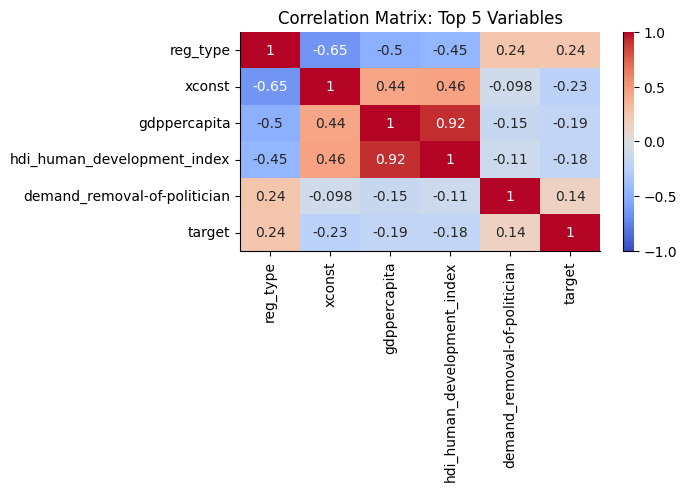

In [ ]:
from scipy.stats import pointbiserialr


# Calculate point-biserial correlation coefficients
continuous_vars = my_data.select_dtypes(include=[np.number]).drop(['target', 'target_6m', 'target_2y'], axis=1).columns
correlations = {var: pointbiserialr(my_data[var], my_data['target'])[0] for var in continuous_vars}
correlations = pd.Series(correlations).apply(np.abs).nlargest(5).index

# Correlation analysis
correlations_data = my_data[correlations].copy()
correlations_data['target'] = my_data['target']
correlations_matrix = correlations_data.corr()

plt.figure(figsize=(6, 3))
sns.heatmap(correlations_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix: Top 5 Variables")
sns.despine()

# Adjust margins and save the figure
plt.subplots_adjust(bottom=0.15, left=0.15)
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/corr_top_5.png', bbox_inches='tight')
plt.show()

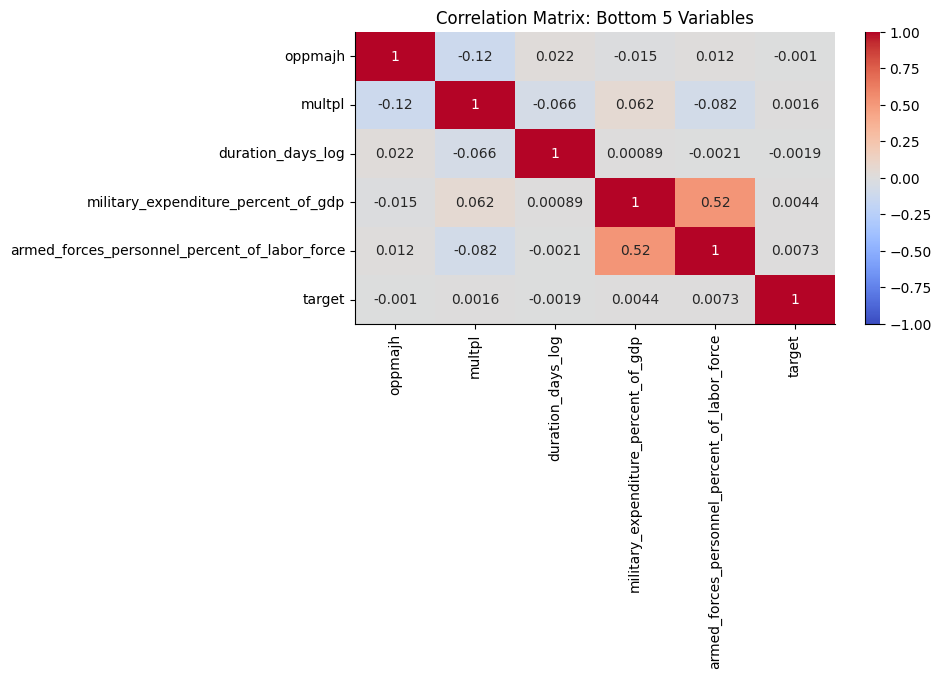

In [ ]:
from scipy.stats import pointbiserialr

# Calculate point-biserial correlation coefficients
continuous_vars = my_data.select_dtypes(include=[np.number]).drop(['target', 'target_6m', 'target_2y'], axis=1).columns
correlations = {var: pointbiserialr(my_data[var], my_data['target'])[0] for var in continuous_vars}
correlations = pd.Series(correlations).apply(np.abs).nsmallest(5).index

# Correlation analysis
correlations_data = my_data[correlations].copy()
correlations_data['target'] = my_data['target']
correlations_matrix = correlations_data.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlations_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix: Bottom 5 Variables")
sns.despine()

# Adjust margins and save the figure
plt.subplots_adjust(bottom=0.15, left=0.15)
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/corr_bottom_5.png', bbox_inches='tight')
plt.show()



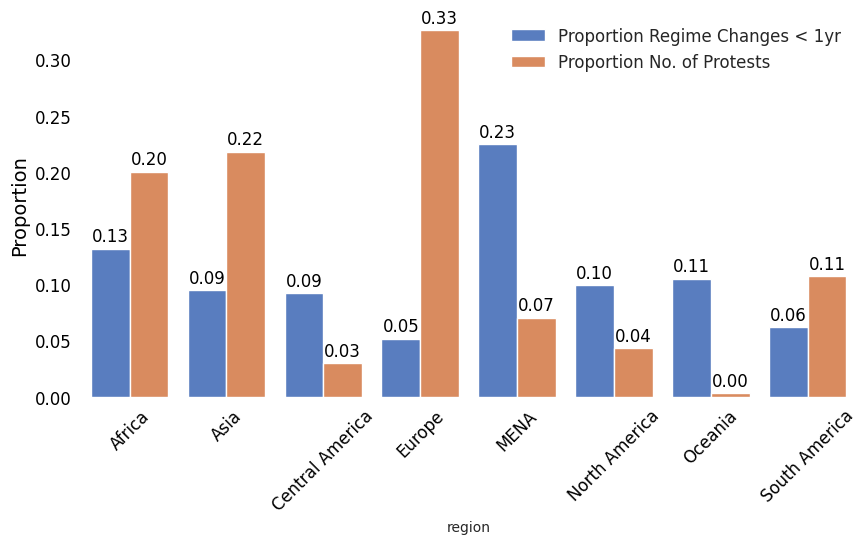

In [ ]:
# Your existing code (assuming data_ is your dataset)
positive_cases = data_.groupby('region')['target'].mean()
total_cases = data_.groupby('region')['target'].count()
total_cases_proportion = total_cases / data_['target'].count()
combined_data = pd.DataFrame({'Proportion Regime Changes < 1yr': positive_cases, 'Proportion No. of Protests': total_cases_proportion})
combined_data = combined_data.reset_index()

plt.figure(figsize=(10, 5))
sns.set_style("white")
barplot = sns.barplot(x='region', y='value', hue='variable', data=pd.melt(combined_data, id_vars='region', var_name='variable', value_name='value'), palette="muted")

# Add data labels with black color
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'baseline',
                     size=12,
                     xytext = (0, 5),
                     textcoords = 'offset points',
                     color='black')

plt.ylabel("Proportion", fontsize=14, color='black')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.legend(title_fontsize='13', loc='upper right', fontsize='12', facecolor='white', edgecolor='white')
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/reg_dist.png',  bbox_inches='tight')
plt.show()


# Preprocessing

In [ ]:
def one_hot_encode(df):
    # categorical_variables = ['region', 'system']
    categorical_variables = ['system']
    for variable in categorical_variables:
        dummies = pd.get_dummies(df[variable], prefix=variable)
        df = pd.concat([df, dummies], axis=1)
        df.drop([variable], axis=1, inplace=True)
    return df
encoded_df = one_hot_encode(my_data)
my_data = encoded_df.copy()

my_data.shape
# 'system_Assembly-Elected President'

(11394, 58)

In [ ]:
x = my_data.drop(['target','target_6m','target_2y','country', 'region'], axis = 1)
y = my_data['target']

periods_str = y.name
if periods_str == 'target':
    period = '1 Year'
elif periods_str == 'target_2y':
    period = '2 Years'
else:
    period = '6 Months'

LABELS = [f"Regime Change.: >= {period}", f"Regime Change.: < {period}"]

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming your data is in the 'my_data' variable
x = my_data.drop(['target', 'target_6m', 'target_2y', 'country', 'region', 'system_Assembly-Elected President'], axis=1)
y = my_data['target']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=42)

# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Apply LASSO with cross-validation
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(x_train_scaled, y_train)

# Get the coefficients
coef = lasso_cv.coef_

# Identify the most informative features
informative_features = x.columns[coef != 0]
x = x[informative_features]

print("Informative features:")
print(informative_features)
print("\nInformative x:")
print(x.shape)

Informative features:
Index(['demand_labor-wage-dispute', 'demand_land-farm-issue',
       'demand_police-brutality', 'demand_political-behavior/process',
       'demand_price-increases/tax-policy', 'demand_removal-of-politician',
       'demand_social-restrictions', 'duration_days_log', 'yrsoffc',
       'finittrm', 'yrcurnt', 'termlimit', 'reelect', 'multpl', 'military',
       'defmin', 'execnat', 'oppmajh', 'legelec', 'exelec', 'liec', 'eiec',
       'gq', 'gqi', 'auton', 'numvote', 'oppvote', 'maj', 'herfgov', 'frac',
       'govfrac', 'tensys_strict', 'checks', 'stabs_strict', 'tenlong_strict',
       'tenshort_strict', 'xconst', 'reg_type',
       'armed_forces_personnel_percent_of_labor_force',
       'aged_15_64_labour_force_participation_rate_percent',
       'exports_percent_of_gdp', 'investments_percent_of_gdp',
       'hdi_human_development_index', 'military_expenditure_percent_of_gdp',
       'log_past_12mo_protests', 'log_cum_participants', 'gdppercapita',
       'total_

In [ ]:
# Arab Spring Cases "2010/2011"

algeria_as = [72, 73]

egypt_as = [2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761]

iran_as = [4949,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976]

iraq_as = [5032,5033,5034,5035,5036,5037,5038,5039,5040,5041,5042,5043,5044,5045,5046,5047,5048,5049,5050,5051]

lebanon_as = [6533,6534,6535,6536]

syria_as = [9514,9515,9516]

tinisia_as = [9970,9971,9972,9973,9974,9975,9976,9977,9978,9979]

yemen_as = [11068,11069,11070,11071,11072,11073,11074,11075,11076,11077,11078,11079,11080,11081,11082,11083,11084,11085,11086,11087,11088,11089,11090,11091,11092,11093,11094,11095,11096,11097,11098,11099,11100,11101,11102,11103,11104,11105,11106,11107,11108,11109,11110,11111,11112,11113,11114,11115,11116,11117,11118,11119,11120,11121,11122,11123,11124,11125,11126,11127,11128,11129,11130,11131,11132,11133,11134,11135,11136,11137,11138,11139,11140,11141,11142,11143,11144]

# Euromaidan Protests - Ukraine

ukrain_eu = [10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278]

# Yellow Vest Movement

france_yvm = [3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312]

#
high_profile = algeria_as + egypt_as + iran_as + iraq_as + lebanon_as + syria_as + tinisia_as + yemen_as + ukrain_eu + france_yvm
len(high_profile)

294

## Baseline Logistic

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

# Splitting the data into training and testing sets
x_train, x_tes, y_train, y_tes = train_test_split(x, y, test_size=0.3, shuffle=True)

# Selecting the indexes of the training data that have yy_train equal to 0
train_idxx = x_train[y_train == 0].index.values
train_idxx = [x for x in train_idxx if x not in high_profile]

# y_test
test_idxx = list(x_tes.index.values)
test_idxx = set(test_idxx + high_profile)


# Selecting only the rows from x1_train that have the indexes in train_idxx
x_train_ae = x[x.index.isin(train_idxx)]
y_train_ae = y[y.index.isin(train_idxx)]
y_train = y[y.index.isin(x_train.index.values)]
# # Test subsets
x_test = x[x.index.isin(test_idxx)]
y_test = y[y.index.isin(test_idxx)]

# Scaling the data using MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train_ae = scaler.transform(x_train_ae)

In [ ]:
# Define the number of splits for cross-validation
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True)

# Initialize the logistic regression model
Model_1 = LogisticRegression(max_iter=8000)

# Initialize variables to store metrics for each fold
accuracies = []
precisions = []

# Perform cross-validation
for train_index, val_index in kf.split(x_train):
    xx_train, xx_val = x.iloc[train_index], x.iloc[val_index]
    yy_train, yy_val = y.iloc[train_index], y.iloc[val_index]


    # Train the model on the training data
    Model_1.fit(xx_train, yy_train)

    # Validate the model on the validation data
    predictions = Model_1.predict(xx_val)

    # Calculate and store the accuracy and precision for the current fold
    accuracies.append(accuracy_score(yy_val, predictions))
    precisions.append(precision_score(yy_val, predictions, average=None))

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions, axis=0)

# Evaluate the model on the test set
prediction = Model_1.predict(pd.DataFrame(x_tes, columns = x.columns, index = y_tes.index))
print_scores(prediction, y_tes)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_tes, prediction)

- f1: 0.2021857923497268
- accuracy: 0.9145949107926294
- precision: 0.5
- recall: 0.1267123287671233


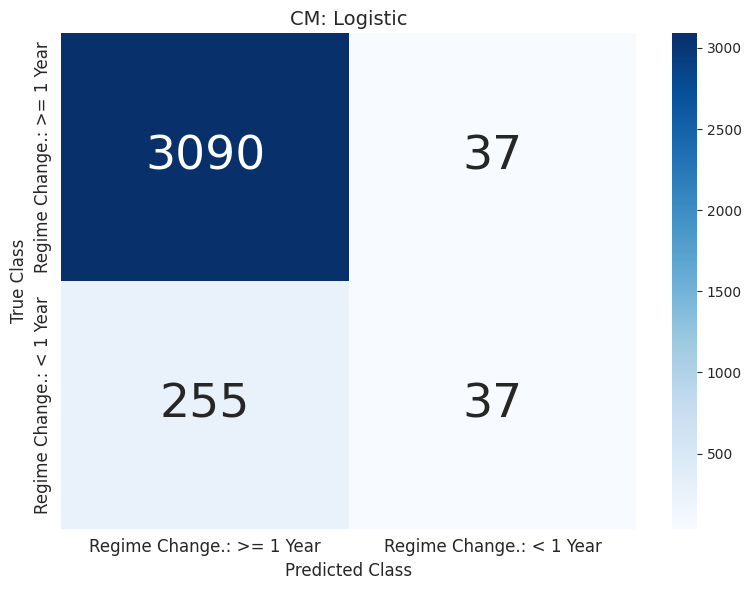

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels= LABELS , yticklabels = LABELS, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 34})
ax.set_xticklabels(LABELS, fontsize=12)
ax.set_yticklabels(LABELS, fontsize=12)
plt.title("CM: Logistic", fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Confusion_Matrix_LR.png')
plt.show()

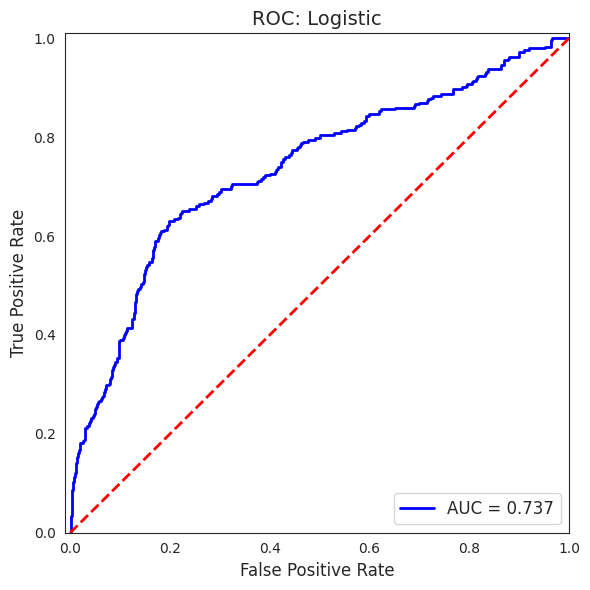

In [ ]:
# Evaluate the model on the test set and get predicted probabilities
probs = Model_1.predict_proba(x_tes)
probs = probs[:, 1]  # Keep only the probabilities for the positive class

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_tes, probs)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, linewidth=2, label='AUC = %0.3f'% roc_auc, color='blue')
ax.plot([0,1],[0,1], linewidth=2, color='red', linestyle='--')

ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.legend(loc='lower right', fontsize=12)
ax.set_title('ROC: Logistic', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/ROC_LR.png')
plt.show()


## Autoencoder Anomomaly detection

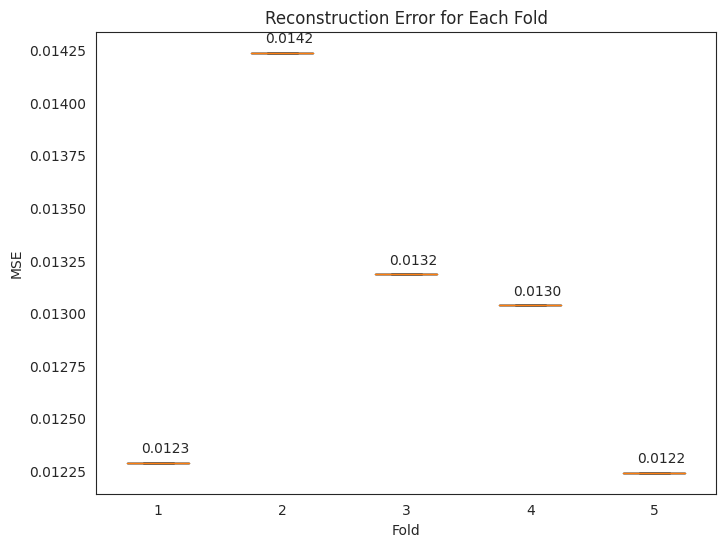

Average reconstruction error: 0.013102633319795132


In [ ]:
def report_average_reconstruction_error(x_train_ae):
    num_splits = 5
    kf = KFold(n_splits=num_splits, shuffle=True)

    # Initialize variables to store metrics for each fold
    losses = []
    mse_scores = [[] for _ in range(num_splits)]

    # Perform cross-validation
    for fold_idx, (train_index, val_index) in enumerate(kf.split(x_train_ae)):
        xx_train, xx_val = x_train_ae[train_index], x_train_ae[val_index]

        # Define the autoencoder model
        input_dim = x_train_ae.shape[1]
        input_layer = Input(shape=(input_dim,))

        # Encoder
        e = Dense(input_dim, activity_regularizer=regularizers.l1(10e-7))(input_layer)
        e = BatchNormalization()(e)
        e = ReLU()(e)
        e = Dense(int(input_dim/2), activity_regularizer=regularizers.l1(10e-7))(e)
        e = BatchNormalization()(e)
        e = ReLU()(e)

        # Bottleneck
        n_bottleneck = round(float(input_dim) / 4.0)
        bottleneck = Dense(n_bottleneck, activity_regularizer=regularizers.l1(10e-7))(e)

        # Decoder
        d = Dense(int(input_dim/2), activity_regularizer=regularizers.l1(10e-7))(bottleneck)
        d = BatchNormalization()(d)
        d = ReLU()(d)
        d = Dense(input_dim, activity_regularizer=regularizers.l1(10e-7))(d)
        d = BatchNormalization()(d)
        d = ReLU()(d)

        # Output layer
        output = Dense(input_dim,  activation='linear', activity_regularizer=regularizers.l1(10e-7))(d)

        # Define autoencoder model
        model = Model(inputs=input_layer, outputs=output)

        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

        history = model.fit(xx_train, xx_train,
                            epochs=1000,
                            batch_size=128,
                            shuffle=True,
                            validation_data=(xx_val, xx_val),
                            verbose=0, callbacks=[early_stop])

        losses.append(history.history['loss'][-1])
        mse_scores[fold_idx].append(history.history['mse'][-1])

    # Calculate the average reconstruction error across all folds
    avg_reconstruction_error = np.mean(losses)

    # Visualize the reconstruction error using a boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    bp = ax.boxplot(mse_scores)
    plt.title('Reconstruction Error for Each Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')

    # Add data labels to the boxplot
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]
        ax.annotate(f'{mse_scores[i][0]:.4f}', (x, y), xytext=(0, 5),
                    textcoords='offset points', ha='right', va='bottom')

    plt.show()

    return avg_reconstruction_error, model, history,  mse_scores

# Call the function with the training data
average_reconstruction_error, model, history,  mse_scores = report_average_reconstruction_error(x_train_ae)
print("Average reconstruction error:", average_reconstruction_error)

In [ ]:
# Function to compute reconstruction error vs class
def reconstruction_error_vs_class(model, sample, y):
    reconstruction = model.predict(sample)
    if len(sample.shape) == 3:
        sample = sample.reshape(sample.shape[0], -1)
        reconstruction = reconstruction.reshape(reconstruction.shape[0], -1)
    reconstruction_error = np.mean(np.power(sample - reconstruction, 2), axis=1)
    return pd.DataFrame({'reconstruction_error': reconstruction_error,
                         'true_class': y})

# Compute the reconstruction error vs class on the test set
error_vs_class_valid = reconstruction_error_vs_class(
    model=model,
    sample=x_test,
    y=y_test)

114/114 [==============================] - 0s 2ms/step


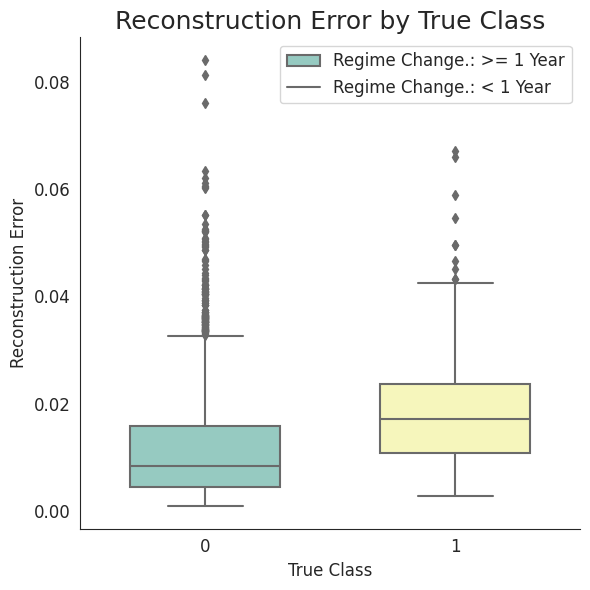

In [ ]:
# Create a boxplot of the reconstruction error vs true class
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_vs_class_valid, ax=ax, palette='Set3', width=0.6)

ax.set_xlabel('True Class', fontsize=12)
ax.set_ylabel('Reconstruction Error', fontsize=12)
ax.set_title('Reconstruction Error by True Class', fontsize=18)
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title='', loc='upper right', labels = LABELS , fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Reconstruction_Box.png')
plt.show()

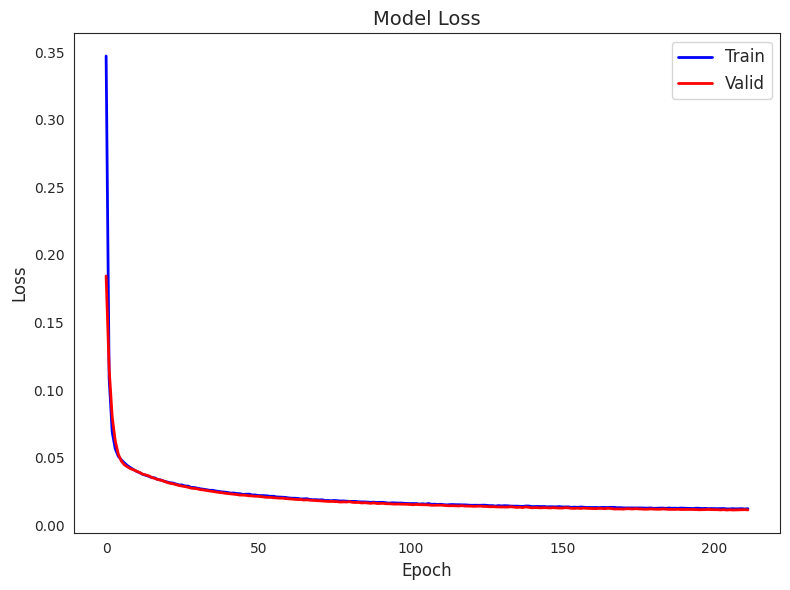

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], linewidth=2, label='Train', color='blue')
ax.plot(history.history['val_loss'], linewidth=2, label='Valid', color='red')
ax.legend(loc='upper right', fontsize=12)
ax.set_title('Model Loss', fontsize=14)
ax.set_ylabel('Loss', fontsize=12)
ax.set_xlabel('Epoch', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Model_loss.png')
plt.show()

In [ ]:
predicted = model.predict(x_test)

test_mse = np.mean(np.power(x_test - predicted, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': test_mse, 'True_class': y_test})
error_df.head()

114/114 [==============================] - 0s 2ms/step


,Reconstruction_error,True_class
3,0.008133,0
9,0.008901,0
11,0.009175,0
12,0.013986,0
13,0.011361,0


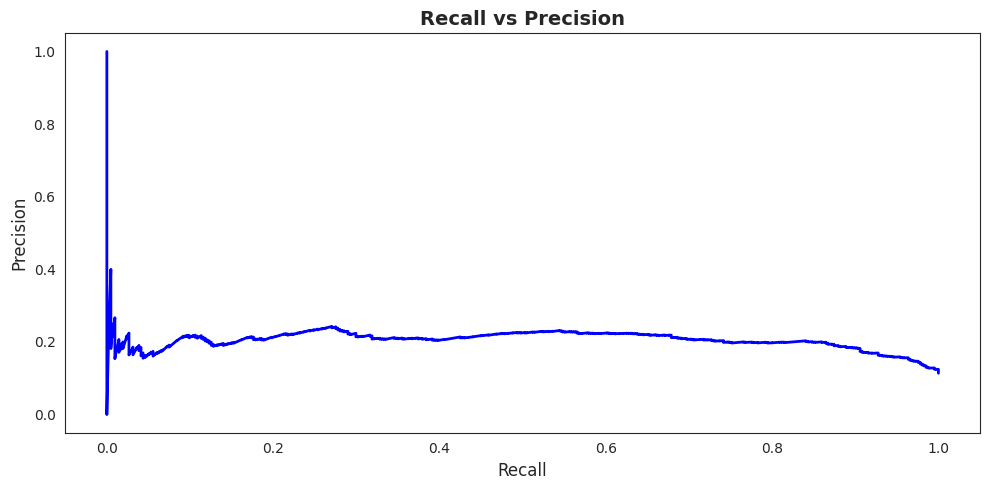

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve', color='blue')
ax.set_title('Recall vs Precision', fontsize=14, fontweight='bold')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Precision_Recall.png')
plt.show()


0.0242


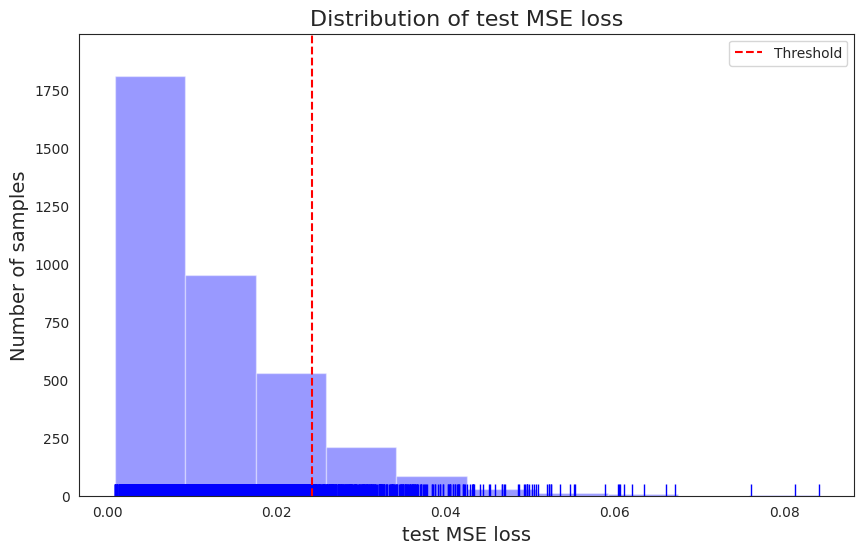

In [ ]:
intersection = np.argwhere(np.diff(np.sign(precision_rt[1:] - recall_rt[1:]))).flatten()
threshold_intersection = threshold_rt[intersection]
threshold_value = round(list(threshold_intersection)[0],4)
# threshold_value = 0.02
print(threshold_value)


plt.figure(figsize=(10,6))
sns.distplot(test_mse, bins=10, kde=False, rug=True, color='blue')
plt.xlabel("test MSE loss", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.title("Distribution of test MSE loss", fontsize=16)
plt.axvline(x=threshold_value, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/MSE_Dist.png')
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mse >= threshold_value).tolist()
# print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))

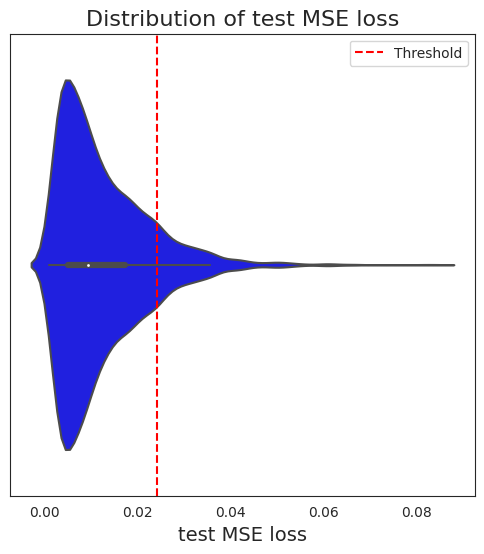

In [ ]:
plt.figure(figsize=(6,6))
sns.violinplot(x=test_mse, color='blue')
plt.xlabel("test MSE loss", fontsize=14)
plt.title("Distribution of test MSE loss", fontsize=16)
plt.axvline(x=threshold_value, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/MSE_Dist_Violin.png')
plt.show()


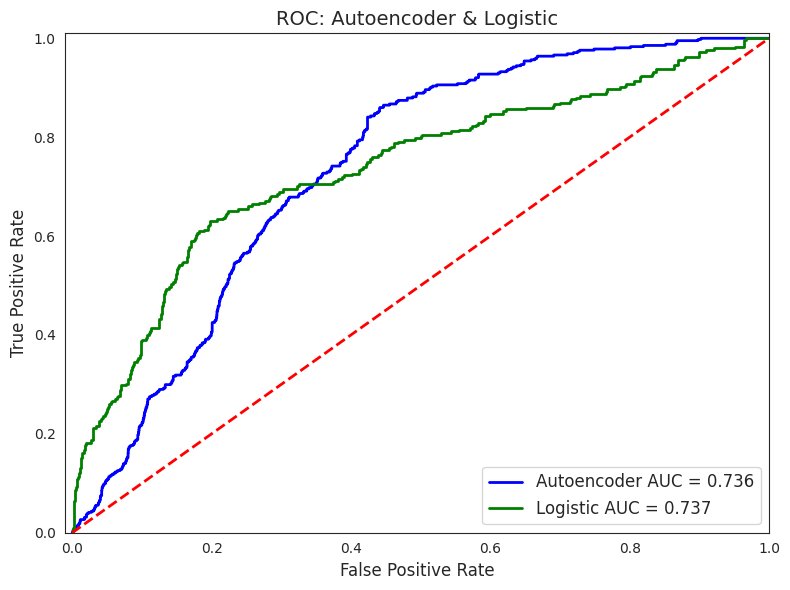

In [ ]:
from sklearn.metrics import roc_curve, auc

# Autoencoder ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc_ae = auc(false_pos_rate, true_pos_rate)

# Logistic model ROC curve
probs = Model_1.predict_proba(x_tes)
probs = probs[:, 1]  # Keep only the probabilities for the positive class
fpr, tpr, _ = roc_curve(y_tes, probs)
roc_auc_lr = auc(fpr, tpr)

# Create a single plot with both ROC curves
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(false_pos_rate, true_pos_rate, linewidth=2, label='Autoencoder AUC = %0.3f'% roc_auc_ae, color='blue')
ax.plot(fpr, tpr, linewidth=2, label='Logistic AUC = %0.3f'% roc_auc_lr, color='green')
ax.plot([0,1],[0,1], linewidth=2, color='red', linestyle='--')

ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.legend(loc='lower right', fontsize=12)
ax.set_title('ROC: Autoencoder & Logistic', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/ROC_combined.png')
plt.show()


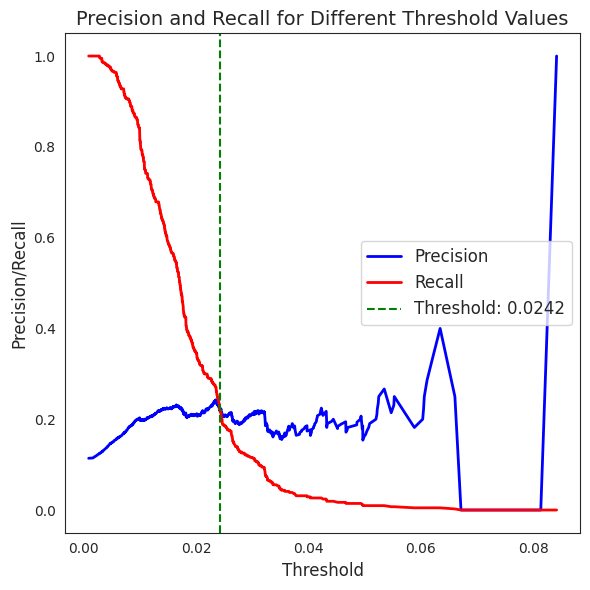

In [ ]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=2, color='blue')
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=2, color='red')
plt.title('Precision and Recall for Different Threshold Values', fontsize=14)
plt.axvline(x=threshold_value, color='green', linestyle='--', label=f"Threshold: {threshold_value}")
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Precision/Recall', fontsize=12)
plt.gcf().set_size_inches(6, 6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Precision_Recall_Tresh.png')
plt.show()


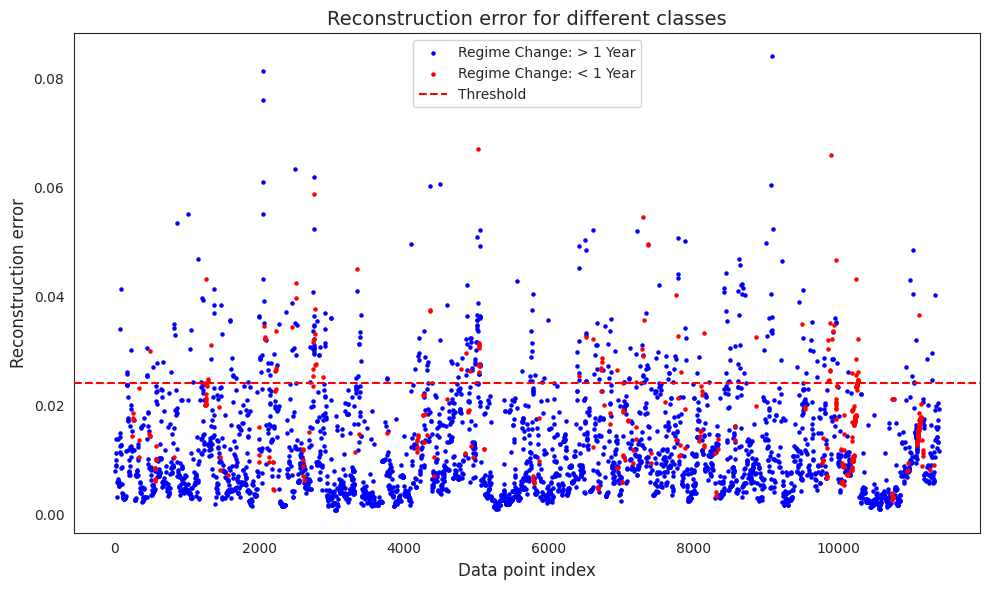

In [ ]:
threshold_fixed = threshold_value
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in groups:
    color = "red" if name == 1 else "blue"
    label = f'Regime Change: < {period}' if name == 1 else f'Regime Change: > {period}'
    ax.scatter(group.index.values, group.Reconstruction_error.values, marker='o', s=5,
               color=color, label=label)

ax.axhline(threshold_fixed, color='r', linestyle='--', label='Threshold', zorder=100)
ax.legend()
plt.title("Reconstruction error for different classes", fontsize=14)
plt.ylabel("Reconstruction error", fontsize=12)
plt.xlabel("Data point index", fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Reconstruction_Error_Class.png')
plt.show()

114/114 [==============================] - 0s 2ms/step


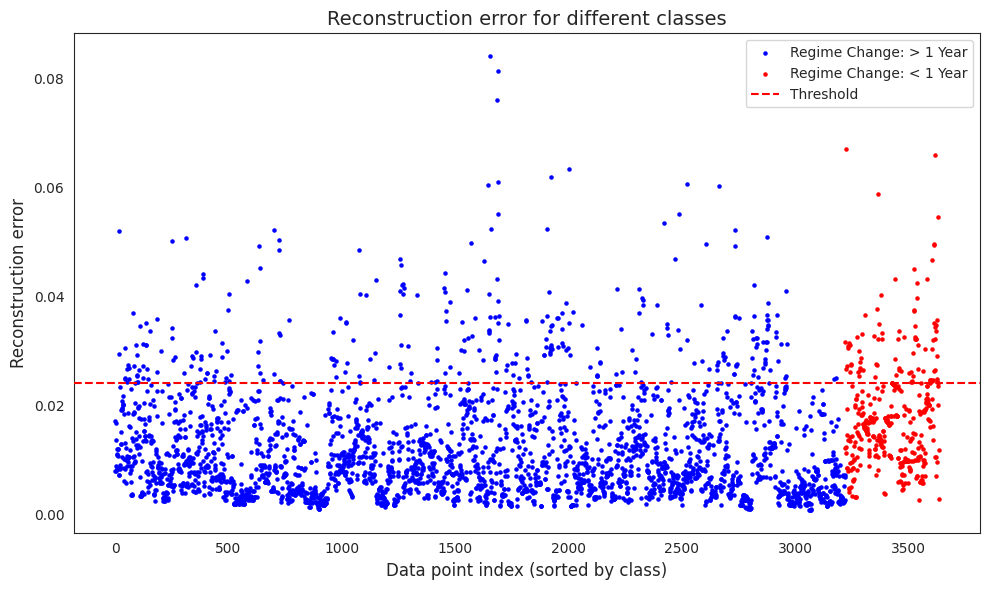

In [ ]:
# Convert x_test to a DataFrame and inherit column names and indices
x_test_df = pd.DataFrame(x_test, columns=x.columns, index=y_test.index)

# Combine x_test DataFrame and y_test Series
combined_df = pd.concat([x_test_df, y_test.rename('True_class')], axis=1)

# Sort the combined DataFrame by the 'True_class' column
sorted_df = combined_df.sort_values(by='True_class')

# Extract the sorted x_test and y_test
x_test_sorted = sorted_df.drop('True_class', axis=1)
y_test_sorted = sorted_df['True_class']

# Apply the autoencoder to the sorted x_test
predicted_sorted = model.predict(x_test_sorted.values)  # Convert sorted x_test back to a numpy array

# Calculate the reconstruction error
test_mse = np.mean(np.power(x_test_sorted.values - predicted_sorted, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': test_mse, 'True_class': y_test_sorted})

# Plot the reconstruction error for different classes
threshold_fixed = threshold_value
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(10, 6))

plot_index = 0

for name, group in groups:
    color = "red" if name == 1 else "blue"
    label = f'Regime Change: < {period}' if name == 1 else f'Regime Change: > {period}'
    group_size = len(group)

    ax.scatter(range(plot_index, plot_index + group_size),
               group.Reconstruction_error.values, marker='o', s=5,
               color=color, label=label)

    plot_index += group_size

ax.axhline(threshold_fixed, color='r', linestyle='--', label='Threshold', zorder=100)
ax.legend()
plt.title("Reconstruction error for different classes", fontsize=14)
plt.ylabel("Reconstruction error", fontsize=12)
plt.xlabel("Data point index (sorted by class)", fontsize=12)
plt.tight_layout()
plt.grid(False)
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/Reconstruction_Error_Class_.png')
plt.show()

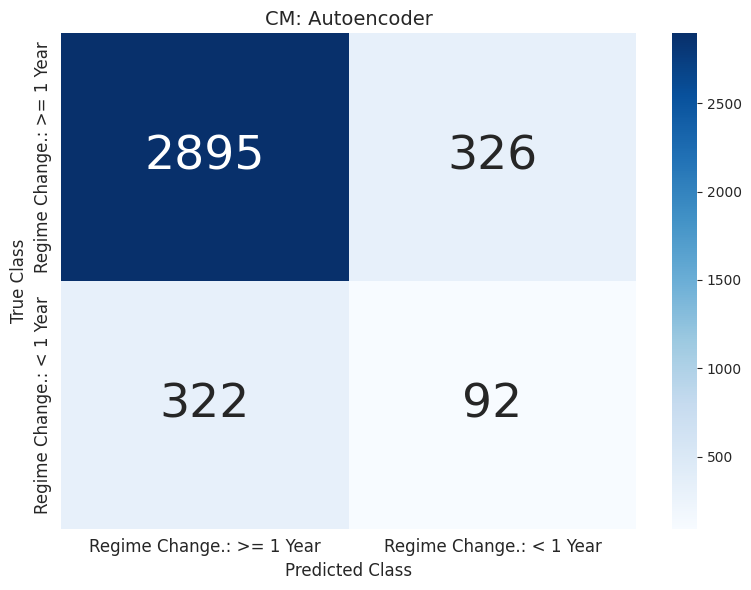

In [ ]:
y_val_pred = [1 if e >= threshold_value  else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_val_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels= LABELS , yticklabels = LABELS, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 34})
ax.set_xticklabels(LABELS, fontsize=12)
ax.set_yticklabels(LABELS, fontsize=12)
plt.title("CM: Autoencoder", fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/confusion_matrix_AE.png')
plt.show()


In [ ]:
confusion_matrix(y_test, y_val_pred)

array([[2858,  363],
       [ 359,   55]])

In [ ]:
top_anomalies = error_df[error_df.Reconstruction_error > threshold_value]

In [ ]:
from datetime import datetime
from matplotlib.dates import AutoDateLocator, DateFormatter

'''
add country name variable to this function 'plot_reconstruction_errors_(title_str,error_df, indices_sub, data_, threshold=threshold_value):

add modify this line to automativally save the viaulization: plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{country_name}.png')
'''

def plot_reconstruction_errors_(country_name, title_str,error_df, indices_sub, data_, threshold=threshold_value):
    # Set the colors for the two classes
    colors = {0: 'blue', 1: 'red'}

    # Create a new column in the dataframe for the colors
    error_df['Color'] = error_df['True_class'].apply(lambda x: colors[x])

    # Filter indices associated with indices subset
    yemen_error_df = error_df[error_df.index.isin(indices_sub)]

    # Get the corresponding dates for the index_subset and convert them to datetime objects
    date_labels = data_.loc[indices_sub, 'startdated'].apply(lambda date_str: datetime.strptime(date_str, '%d/%m/%Y'))

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(date_labels, yemen_error_df['Reconstruction_error'], c=yemen_error_df['Color'], label='No Regime Change < 1 Year')

    # Draw the reconstruction error threshold line
    ax.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')

    # Add labels and title
    # ax.set_xlabel('Date')
    ax.set_xticks(date_labels)
    ax.set_xticklabels(date_labels, rotation=90)
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
    ax.set_ylabel('Reconstruction Error')
    ax.set_title(title_str)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{country_name}.png')
    plt.show()

In [ ]:
def plot_reconstruction_errors(country_name, title_str, error_df, indices_sub, data_, event_date_str, threshold=threshold_value):
    # Set the colors and labels for the two classes
    colors = {0: 'blue', 1: 'red'}
    labels = {0: f'Regime Change: >= {period}', 1: f'Regime Change: < {period}'}

    # Create a new column in the dataframe for the colors
    error_df['Color'] = error_df['True_class'].apply(lambda x: colors[x])

    # Filter indices associated with  indices subset
    yemen_error_df = error_df[error_df.index.isin(indices_sub)]

    # Get the corresponding dates for the index_subset and convert them to datetime objects
    date_labels = data_.loc[indices_sub, 'startdated'].apply(lambda date_str: datetime.strptime(date_str, '%d/%m/%Y'))

    # Convert the event_date_str to a datetime object
    event_date = datetime.strptime(event_date_str, '%d/%m/%Y')
    event_date1 = datetime.strptime('11/02/2011', '%d/%m/%Y')

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(6, 4))
    for true_class in colors:
        ax.scatter(date_labels[yemen_error_df['True_class'] == true_class],
                   yemen_error_df.loc[yemen_error_df['True_class'] == true_class, 'Reconstruction_error'],
                   c=colors[true_class], label=labels[true_class])

    # Draw the reconstruction error threshold line
    ax.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')

    # Add a vertical text label for the event date
    ax.axvline(event_date, color='red', linestyle='--', label='2nd Regime Transition')

    ax.text(event_date, ax.get_ylim()[1] * 0.5, f"{event_date_str}", color='red', fontsize=10,
            bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.2'),
            rotation='vertical', verticalalignment='center')

    ax.axvline(event_date1, color='red', linestyle='--', label='1st Regime Transition')

    ax.text(event_date1, ax.get_ylim()[1] * 0.5, f"{event_date_str}", color='red', fontsize=10,
            bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.2'),
            rotation='vertical', verticalalignment='center')


    # Add labels and title
    ax.set_xticks(date_labels)
    ax.set_xticklabels(date_labels, rotation=90)
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
    ax.set_ylabel('Reconstruction Error')
    ax.set_title(title_str)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{country_name}.png')
    plt.show()


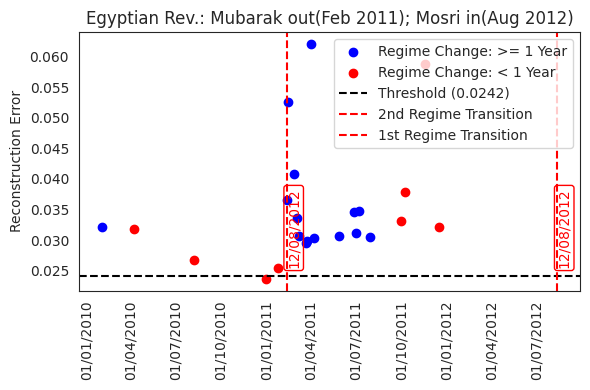

In [ ]:
# Call the function with the index subset yemen_ae, the data, and the event date

plot_reconstruction_errors('egypt','Egyptian Rev.: Mubarak out(Feb 2011); Mosri in(Aug 2012)', error_df, egypt_as, data_, '12/08/2012', threshold=threshold_value)
# plot_reconstruction_errors('Yemen Revolution: End of Pres. Ali Abdullah Saleh Feb 2012', error_df, yemen_as, data_, '21/02/2012' , threshold=threshold_value)

# Ousting of President Hosni Mubarak in Feb 2011 and Beggining of Pres. Moh Mosri Aug 2012

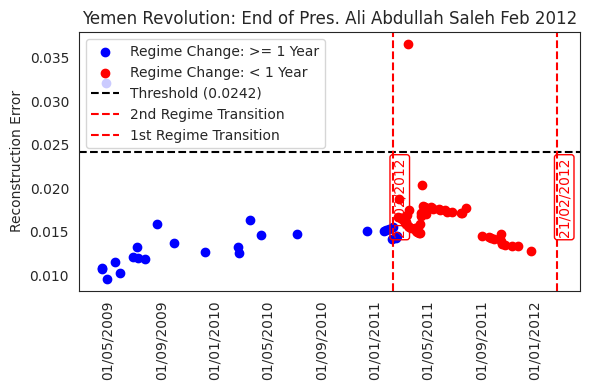

In [ ]:
plot_reconstruction_errors('yemen','Yemen Revolution: End of Pres. Ali Abdullah Saleh Feb 2012', error_df, yemen_as, data_, '21/02/2012' , threshold=threshold_value)

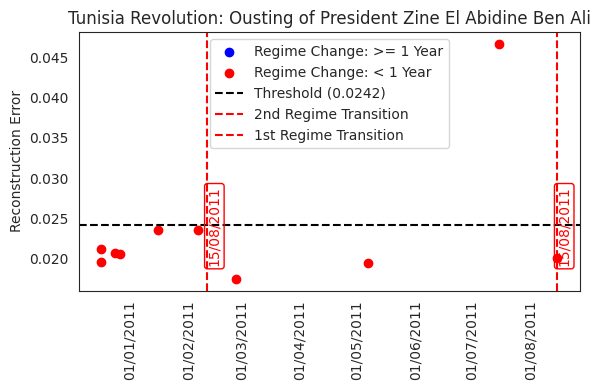

In [ ]:
plot_reconstruction_errors('tunisia','Tunisia Revolution: Ousting of President Zine El Abidine Ben Ali', error_df, tinisia_as, data_, '15/08/2011' , threshold=threshold_value)

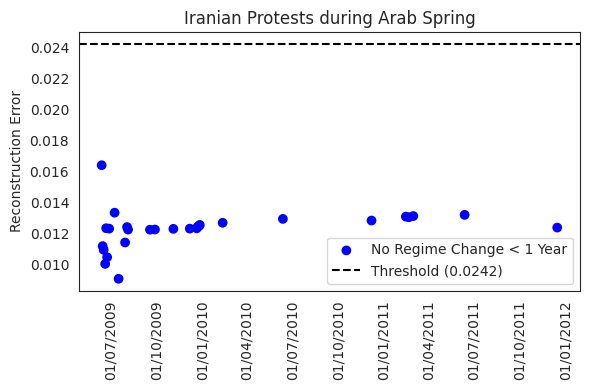

In [ ]:
plot_reconstruction_errors_('iran','Iranian Protests during Arab Spring',error_df, iran_as, data_, threshold=threshold_value)

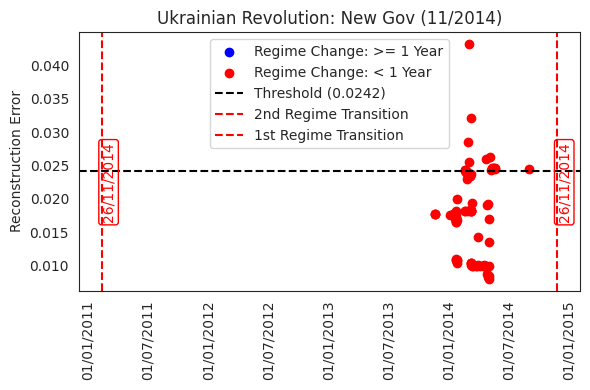

In [ ]:
plot_reconstruction_errors('ukraine','Ukrainian Revolution: New Gov (11/2014)',error_df, ukrain_eu, data_, '26/11/2014', threshold=threshold_value)
# after Ousting Pres. Viktor Yanukovych

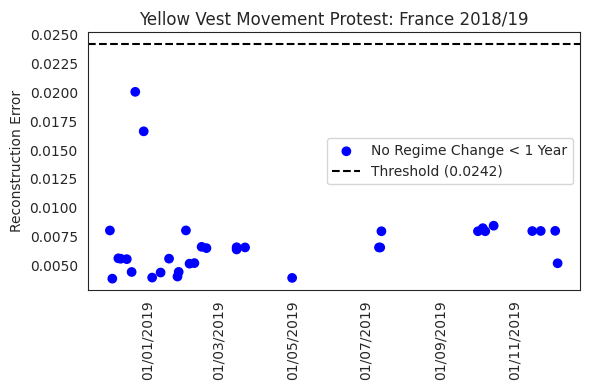

In [ ]:
plot_reconstruction_errors_('france','Yellow Vest Movement Protest: France 2018/19',error_df, france_yvm, data_, threshold=threshold_value)

In [ ]:
# # Arab Spring Cases "2010/2011"

# algeria_as = [72, 73]

# egypt_as = [2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761]

# iran_as = [4949, 4950,4951,4952,4953,4954,4955,4956,4957,4958,4959,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976]

# iraq_as = [5032,5033,5034,5035,5036,5037,5038,5039,5040,5041,5042,5043,5044,5045,5046,5047,5048,5049,5050,5051]

# lebanon_as = [6533,6534,6535,6536]

# syria_as = [9514,9515,9516]

# tinisia_as = [9970,9971,9972,9973,9974,9975,9976,9977,9978,9979]

# yemen_as = [11068,11069,11070,11071,11072,11073,11074,11075,11076,11077,11078,11079,11080,11081,11082,11083,11084,11085,11086,11087,11088,11089,11090,11091,11092,11093,11094,11095,11096,11097,11098,11099,11100,11101,11102,11103,11104,11105,11106,11107,11108,11109,11110,11111,11112,11113,11114,11115,11116,11117,11118,11119,11120,11121,11122,11123,11124,11125,11126,11127,11128,11129,11130,11131,11132,11133,11134,11135,11136,11137,11138,11139,11140,11141,11142,11143,11144]

# # Euromaidan Protests - Ukraine

# ukrain_eu = [10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278]

# # Yellow Vest Movement

# france_yvm = [3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312]

# #
# high_profile = algeria_as + egypt_as + iran_as + iraq_as + lebanon_as + syria_as + tinisia_as + yemen_as + ukrain_eu + france_yvm
# len(high_profile)

In [ ]:
print_scores(y_val_pred, y_test)

# anomaly_idx = [ 7830,  5034,  5036,  2108,  6878,  7295,  4914, 10263,  2439,
#              2046,  2071,  7408,  6721,  9454,  2045, 10271,  8111,  7875,
#             10276,  1287,  1269,  2438,  1277,  8995,  8096,  6726,  2774,
#              2047,  2760,   271,  6728,  2437,   329,  7874,  2766,  3766,
#              6718,  6731,  2066,  9508,  2441,  2761,  6605,  6732,  1271,
#              2062,  8091, 11120, 11168,  5040,  2724, 10286,  3389,  1274,
#              4789,  9894,  4090, 10962,  9971,  1255,  2770,  8113,  1381,
#              7376,  4491,  1279,  4250,  5037, 10267,  3317,  1262,  1253,
#              2063,  7786,  5039,  2875,  2079,  6615,  4850,  2067]

# 4491, 9894, 9971, 7295, 2760

- f1: 0.13221153846153846
- accuracy: 0.8013755158184319
- precision: 0.13157894736842105
- recall: 0.13285024154589373


In [ ]:
def plot_top_features_error_(country_name,title_str,x_test, model, x, y_test, index_subset, data_):
    # Reconstruct the x_test data using the autoencoder
    reconstructed_x_test = model.predict(x_test)

    # Calculate the reconstruction error for each feature in each instance
    reconstruction_error = np.power(reconstructed_x_test - x_test, 2)

    # Convert the reconstruction_error array into a DataFrame with column names and indices
    reconstruction_error_df = pd.DataFrame(reconstruction_error, columns=x.columns, index=y_test.index)

    # Find the average increase in reconstruction error over time for each feature
    average_error_increase = np.diff(reconstruction_error_df.loc[index_subset].values, axis=0).mean(axis=0)

    # Identify the top two features with the highest average increase in reconstruction error over time
    top_two_features = average_error_increase.argsort()[-2:][::-1]

    # Get the feature names
    feature_names = x.columns[top_two_features]

    # Get the corresponding dates for the index_subset and convert them to datetime objects
    date_labels = data_.loc[index_subset, 'startdated'].apply(lambda date_str: datetime.strptime(date_str, '%d/%m/%Y'))

    # Plot the reconstruction error of the top two features over the indices
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(date_labels, reconstruction_error_df.loc[index_subset, feature_names[0]], label=feature_names[0], marker='o')
    ax.plot(date_labels, reconstruction_error_df.loc[index_subset, feature_names[1]], label=feature_names[1], marker='o')
    # ax.set_xlabel('Date')
    ax.set_xticks(date_labels)
    ax.set_xticklabels(date_labels, rotation=90)
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
    ax.set_ylabel('Reconstruction Error')
    ax.set_title(title_str)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{country_name}.png')
    plt.show()

In [ ]:
def plot_top_features_error(country_name, title_str,x_test, model, x, y_test, index_subset, data_, event_date_str):
    # Reconstruct the x_test data using the autoencoder
    reconstructed_x_test = model.predict(x_test)

    # Calculate the reconstruction error for each feature in each instance
    reconstruction_error = np.power(reconstructed_x_test - x_test, 2)

    # Convert the reconstruction_error array into a DataFrame with column names and indices
    reconstruction_error_df = pd.DataFrame(reconstruction_error, columns=x.columns, index=y_test.index)

    # Find the average increase in reconstruction error over time for each feature
    average_error_increase = np.diff(reconstruction_error_df.loc[index_subset].values, axis=0).mean(axis=0)

    # Identify the top two features with the highest average increase in reconstruction error over time
    top_two_features = average_error_increase.argsort()[-2:][::-1]

    # Get the feature names
    feature_names = x.columns[top_two_features]

    # Get the corresponding dates for the index_subset and convert them to datetime objects
    date_labels = data_.loc[index_subset, 'startdated'].apply(lambda date_str: datetime.strptime(date_str, '%d/%m/%Y'))

    # Convert the event_date_str to a datetime object
    event_date = datetime.strptime(event_date_str, '%d/%m/%Y')

    # Plot the reconstruction error of the top two features over the indices
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(date_labels, reconstruction_error_df.loc[index_subset, feature_names[0]], label=feature_names[0], marker='o')
    ax.plot(date_labels, reconstruction_error_df.loc[index_subset, feature_names[1]], label=feature_names[1], marker='o')
    ax.axvline(event_date, color='red', linestyle='--', label='Regime Transition')

    ax.text(event_date, ax.get_ylim()[1] * 0.5, f"{event_date_str}", color='red', fontsize=10,
            bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.2'),
            rotation='vertical', verticalalignment='center')

    # ax.set_xlabel('Date')
    ax.set_xticks(date_labels)
    ax.set_xticklabels(date_labels, rotation=90)
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
    ax.set_ylabel('Reconstruction Error')
    ax.set_title(title_str)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{country_name}.png')
    plt.show()

114/114 [==============================] - 0s 2ms/step


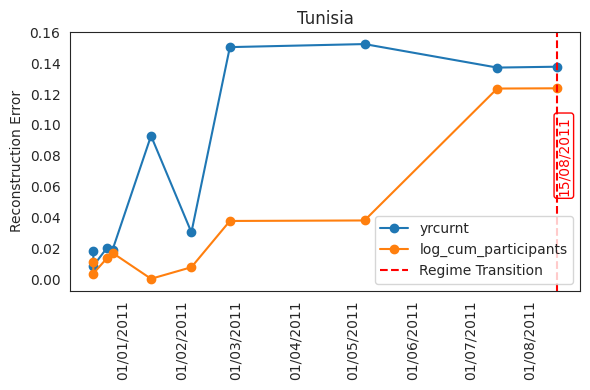

In [ ]:
# Call the function with the index subset yemen_ae and the event date
plot_top_features_error('tunisia_top','Tunisia',x_test, model, x, y_test, tinisia_as, data_,'15/08/2011')

114/114 [==============================] - 0s 2ms/step


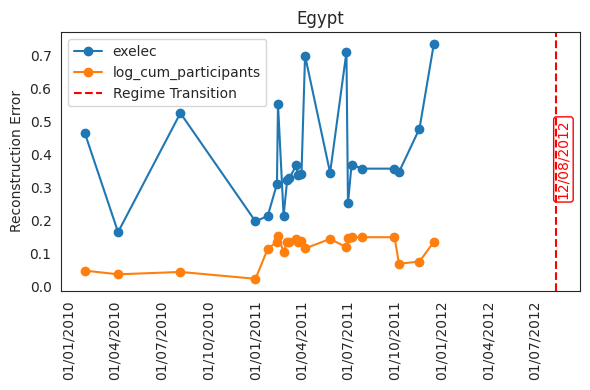

In [ ]:
# Call the function with the index subset yemen_ae and the event date
plot_top_features_error('egypt_top','Egypt',x_test, model, x, y_test, egypt_as, data_,'12/08/2012')

114/114 [==============================] - 0s 2ms/step


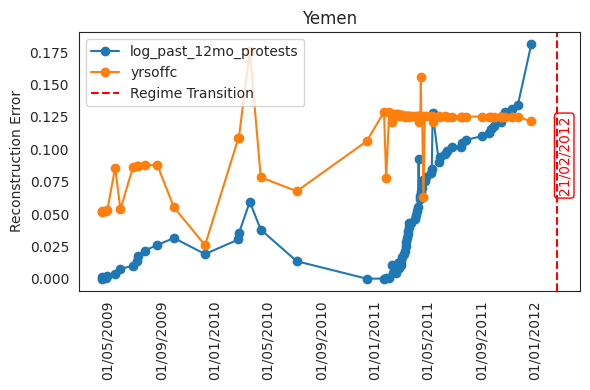

In [ ]:
plot_top_features_error('yemen_top','Yemen',x_test, model, x, y_test, yemen_as, data_,'21/02/2012')

114/114 [==============================] - 0s 2ms/step


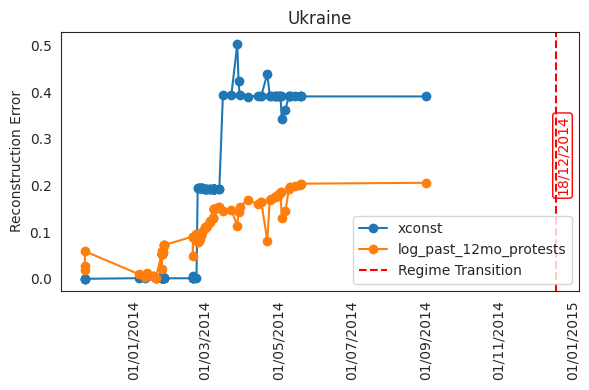

In [ ]:
# Call the function with the index subset ukraine
plot_top_features_error('ukraine_top','Ukraine',x_test, model, x, y_test, ukrain_eu, data_,'18/12/2014')

114/114 [==============================] - 0s 2ms/step


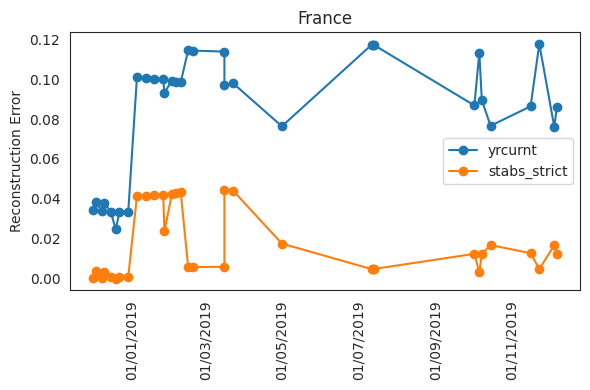

In [ ]:
# Call the function with the index subset france
plot_top_features_error_('france_top','France',x_test, model, x, y_test, france_yvm, data_)

114/114 [==============================] - 0s 2ms/step


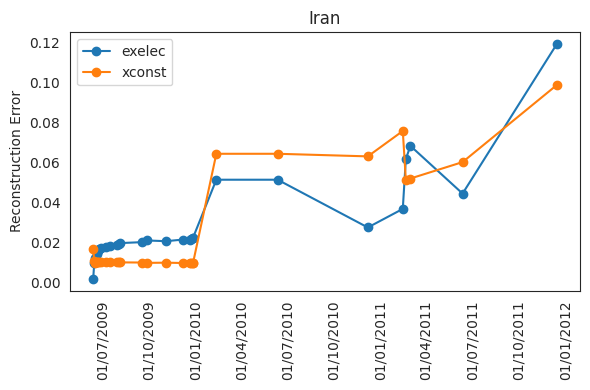

In [ ]:
# Call the function with the index subset iran
plot_top_features_error_('iran_top','Iran',x_test, model, x, y_test, iran_as, data_)

In [ ]:
def calculate_top_features_error(title_str, x_test, model, x, y_test, index_subsets, data_, top_k=5):
    # Reconstruct the x_test data using the autoencoder
    reconstructed_x_test = model.predict(x_test)

    # Calculate the reconstruction error for each feature in each instance
    reconstruction_error = np.power(reconstructed_x_test - x_test, 2)

    # Convert the reconstruction_error array into a DataFrame with column names and indices
    reconstruction_error_df = pd.DataFrame(reconstruction_error, columns=x.columns, index=y_test.index)

    top_feature_importances = []

    # Loop through the index_subsets
    for index_subset in index_subsets:
        # Calculate the average increase in reconstruction error over time for each feature
        average_error_increase = np.diff(reconstruction_error_df.loc[index_subset].values, axis=0).mean(axis=0)

        # Identify the top_k features with the highest average increase in reconstruction error over time
        top_k_features = average_error_increase.argsort()[-top_k:][::-1]

        # Get the feature names
        feature_names = x.columns[top_k_features]

        # Calculate the relative feature importance and percentage of its reconstruction error divided by its value
        relative_importance = []
        for feature in feature_names:
            feature_values = x.loc[index_subset, feature]
            feature_values[feature_values == 0] = 1  # Replace zeros with ones
            feature_importance = reconstruction_error_df.loc[index_subset, feature] / feature_values
            relative_importance.append(feature_importance.mean())

        # Combine the feature names and their relative importance into a single DataFrame
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Relative Importance': relative_importance})
        feature_importance_df['Index Subset'] = index_subset[0]

        # Append the DataFrame to the list of top_feature_importances
        top_feature_importances.append(feature_importance_df)

    # Concatenate the top_feature_importances DataFrames and reset the index
    top_features_df = pd.concat(top_feature_importances, ignore_index=True)

    return top_features_df

index_subsets = [tinisia_as, yemen_as, egypt_as, iran_as, ukrain_eu, france_yvm]
top_features_df = calculate_top_features_error('feature importance', x_test, model, x, y_test, index_subsets, data_)

# Print the resulting DataFrame
top_features_df.to_csv('top_features_df.csv'); top_features_df

114/114 [==============================] - 0s 2ms/step


,Feature,Relative Importance,Index Subset
0,yrcurnt,0.025021,9970
1,log_cum_participants,0.003382,9970
2,govfrac,0.051685,9970
3,xconst,0.009400,9970
4,demand_removal-of-politician,0.068834,9970
5,log_past_12mo_protests,0.014950,11068
6,yrsoffc,0.003456,11068
7,demand_police-brutality,0.031065,11068
8,tenlong_strict,0.001014,11068
9,exelec,0.097431,11068


In [ ]:
def calculate_top_features_error(title_str, x_test, model, x, y_test, index_subsets, data_, top_k=10):
    reconstructed_x_test = model.predict(x_test)
    reconstruction_error = np.power(reconstructed_x_test - x_test, 2)
    reconstruction_error_df = pd.DataFrame(reconstruction_error, columns=x.columns, index=y_test.index)

    top_feature_importances = []

    for index_subset in index_subsets:
        for idx in index_subset:
            total_error = reconstruction_error_df.loc[idx]
            top_k_features = total_error.argsort()[-top_k:][::-1]
            feature_names = x.columns[top_k_features]

            relative_importance = []
            instance_error = []
            feature_values_list = []

            for feature in feature_names:
                feature_value = x.loc[idx, feature]
                feature_value_single = feature_value
                feature_importance_per_instance = reconstruction_error_df.loc[idx, feature] / (feature_value if feature_value != 0 else 1)
                instance_errors = reconstruction_error_df.loc[idx, feature]

                relative_importance.append(feature_importance_per_instance)
                instance_error.append(instance_errors)
                feature_values_list.append(feature_value_single)

            instance_mse = np.mean(reconstruction_error_df.loc[idx].values)

            feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Feature Value': feature_values_list, 'Instance Error': instance_error, 'Relative Importance': relative_importance})
            feature_importance_df['Index'] = idx
            feature_importance_df['Instance MSE'] = instance_mse

            top_feature_importances.append(feature_importance_df)

    top_features_df = pd.concat(top_feature_importances, ignore_index=True)

    return top_features_df

index_subsets = [tinisia_as, yemen_as, egypt_as, iran_as, ukrain_eu, france_yvm]
top_features_df = calculate_top_features_error('feature importance', x_test, model, x, y_test, index_subsets, data_)

# Print the resulting DataFrame
top_features_df


114/114 [==============================] - 0s 2ms/step


,Feature,Feature Value,Instance Error,Relative Importance,Index,Instance MSE
0,aged_15_64_labour_force_participation_rate_per...,50.61,0.107525,0.002125,9970,0.020146
1,duration_days_log,2.302585,0.105753,0.045928,9970,0.020146
2,hdi_human_development_index,0.716,0.096779,0.135166,9970,0.020146
3,gq,2.0,0.090409,0.045205,9970,0.020146
4,execnat,0.0,0.062696,0.062696,9970,0.020146
...,...,...,...,...,...,...
2645,oppvote,0.5089,0.010903,0.021425,3312,0.004439
2646,multpl,1.0,0.008228,0.008228,3312,0.004439
2647,execnat,0.0,0.007487,0.007487,3312,0.004439
2648,demand_social-restrictions,0.0,0.007418,0.007418,3312,0.004439


In [ ]:
2.769473/2

1.3847365

In [ ]:

def calculate_bottom_features_error(title_str, x_test, model, x, y_test, index_subsets, data_, bottom_k=3):
    reconstructed_x_test = model.predict(x_test)
    reconstruction_error = np.power(reconstructed_x_test - x_test, 2)
    reconstruction_error_df = pd.DataFrame(reconstruction_error, columns=x.columns, index=y_test.index)

    bottom_feature_importances = []

    for index_subset in index_subsets:
        total_error = reconstruction_error_df.loc[index_subset].sum()
        bottom_k_features = total_error.argsort()[:bottom_k]  # Change this line to get bottom features
        feature_names = x.columns[bottom_k_features]

        relative_importance = []
        instance_error = []
        feature_values_list = []

        for feature in feature_names:
            feature_importance_per_instance = []
            instance_errors = []
            for idx in index_subset:
                feature_value = x.loc[idx, feature]
                feature_value_single = feature_value
                feature_importance_per_instance.append(reconstruction_error_df.loc[idx, feature] / (feature_value if feature_value != 0 else 1))
                instance_errors.append(reconstruction_error_df.loc[idx, feature])

            relative_importance.append(np.mean(feature_importance_per_instance))
            instance_error.append(np.mean(instance_errors))
            feature_values_list.append(feature_value_single)

        subset_mse = np.mean(reconstruction_error_df.loc[index_subset].values)

        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Feature Value': feature_values_list, 'Instance Error': instance_error, 'Relative Importance': relative_importance})
        feature_importance_df['Index Subset'] = index_subset[0]
        feature_importance_df['Subset MSE'] = subset_mse

        bottom_feature_importances.append(feature_importance_df)

    bottom_features_df = pd.concat(bottom_feature_importances, ignore_index=True)

    return bottom_features_df

index_subsets = [tinisia_as, yemen_as, egypt_as, iran_as, ukrain_eu, france_yvm]
bottom_features_df = calculate_bottom_features_error('feature importance', x_test, model, x, y_test, index_subsets, data_)

# Print the resulting DataFrame
bottom_features_df

114/114 [==============================] - 0s 2ms/step


,Feature,Feature Value,Instance Error,Relative Importance,Index Subset,Subset MSE
0,herfgov,1.000000,0.000158,0.000158,9970,0.023299
1,finittrm,1.000000,0.000161,0.000161,9970,0.023299
2,armed_forces_personnel_percent_of_labor_force,1.228990,0.000344,0.000279,9970,0.023299
3,oppmajh,0.000000,0.000139,0.000139,11068,0.015691
4,herfgov,1.000000,0.000225,0.000225,11068,0.015691
5,maj,0.757475,0.000309,0.000408,11068,0.015691
6,oppmajh,0.000000,0.000031,0.000031,2739,0.035180
7,herfgov,1.000000,0.000075,0.000075,2739,0.035180
8,checks,2.000000,0.000132,0.000066,2739,0.035180
9,demand_social-restrictions,0.000000,0.000257,0.000257,4949,0.012304


In [ ]:
list(range(3))

[0, 1, 2]

$TotalCombinations = \sum_{r=1}^n C_r^n$

In [ ]:
import math

def sum_combinations(n):
    total = 0
    for i in range(n):
        total += math.comb(n, i+1)
    return total + 1

n = 5
print("Total Combinations:", sum_combinations(n))

Total Combinations: 32


In [ ]:
[9970, 4949, 10185, 2739, 11068, 3280]

[9970, 4949, 10185, 2739, 11068, 3280]

In [ ]:
# Explaining Anomalies Using SHAP

X = x.copy()

# Grab the indices of the top anomalies
idx = list(y_test.index)
anomaly_idx = list(top_anomalies.index)
test_idx = set(list(anomaly_idx + idx))

X_test = X.loc[test_idx]

# Define X_train
X_train = X[~X.index.isin(test_idx)]

# Store original indices
X_train_original_indices = X_train.index
X_test_original_indices = X_test.index

# Scale the data
scaler_ = MinMaxScaler()
X_train = scaler_.fit_transform(X_train)
X_test = scaler_.transform(X_test)

# Create new DataFrames with original indices
X_train = pd.DataFrame(X_train, index=X_train_original_indices, columns=list(X.columns))
X_test = pd.DataFrame(X_test, index=X_test_original_indices, columns=list(X.columns))

Y_test = y[~y.index.isin(test_idx)]

In [ ]:
import itertools

x_test = X_test.copy()

x_test_array = x_test.to_numpy()
x_test_indices = x_test.index.to_numpy()

# Assuming you already have the autoencoder 'model' and x_test dataframe
reconstructed_data = model.predict(x_test_array)

# 1. Calculate the reconstruction error (MSE) for each instance in x_test
mse_errors = np.mean(np.square(x_test_array - reconstructed_data), axis=1)

# 2. Retrieve indices of bottom 50 instances with lowest reconstruction error
bottom_error_indices = x_test_indices[np.argpartition(mse_errors, 20)[:20]]

# 3. Find the mode value for each feature in the bottom error index records
normal_values_dict = {}
for idx, feature in enumerate(x_test.columns):
    mode_value = pd.Series(x_test_array[np.isin(x_test_indices, bottom_error_indices)][:, idx]).mode().iloc[0]
    normal_values_dict[feature] = mode_value

# 4. Examine a given error instance of an index
index_to_examine = 10270
index_position = np.where(x_test_indices == index_to_examine)[0][0]

# a. Get the mean reconstruction error for this instance
mean_error = mse_errors[index_position]

# b. Retrieve top 10 features with highest reconstruction error at this instance
instance_error = np.square(x_test_array[index_position] - reconstructed_data[index_position])
top_error_features = instance_error.argsort()[-5:][::-1]

# c. Replace the values of the 'top_error_features' with their corresponding values
def get_combinations_features(features):
    combinations = []
    for r in range(1, len(features) + 1):
        for subset in itertools.combinations(features, r):
            combinations.append(list(subset))
    return combinations

combinations = get_combinations_features(top_error_features)
reconstructed_error_combinations = []

for combination in combinations:
    x_test_modified = x_test_array.copy()
    for feature_idx in combination:
        x_test_modified[index_position, feature_idx] = normal_values_dict[x_test.columns[feature_idx]]

    reconstructed_data_modified = model.predict(x_test_modified)
    mse_error_modified = np.mean(np.square(x_test_modified - reconstructed_data_modified), axis=1)
    reconstructed_error_combinations.append(mse_error_modified[index_position])

114/114 [==============================] - 0s 2ms/step


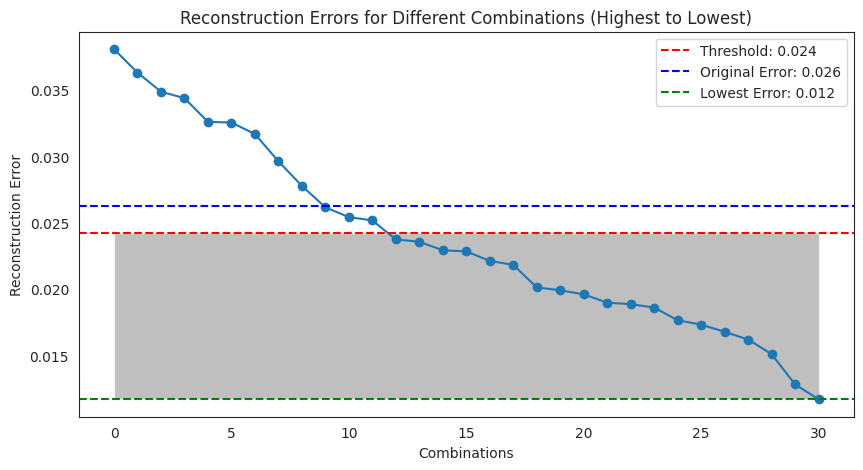

In [ ]:
# Sort reconstructed_error_combinations from highest to lowest
sorted_combinations = sorted(enumerate(reconstructed_error_combinations), key=lambda x: x[1], reverse=True)

# Plot reconstruction errors from highest to lowest
plt.figure(figsize=(10, 5))
plt.plot([x[1] for x in sorted_combinations], marker='o', linestyle='-')

# Fill the entire region between the threshold and 0
plt.fill_between(range(len(combinations)), sorted_combinations[-1][1], threshold_value, facecolor='gray', alpha=0.5)

plt.axhline(y=threshold_value, color='r', linestyle='--', label= f'Threshold: {round(threshold_value,3)}')
plt.axhline(y=mse_errors[index_position], color='b', linestyle='--', label=f'Original Error: {round(mse_errors[index_position],3)}')
plt.axhline(y=sorted_combinations[-1][1], color='g', linestyle='--', label=f'Lowest Error: {round(sorted_combinations[-1][1],3)}')
plt.xlabel('Combinations')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for Different Combinations (Highest to Lowest)')
plt.legend()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/cfa_ukraine.png')
plt.show()

In [ ]:
# Get the combination that yielded the lowest reconstruction error
best_combination_idx, best_combination_error = sorted_combinations[-1]
worst_combination_idx, worst_combination_error = sorted_combinations[0]

# Retrieve the corresponding features, reconstructed values, and original values
best_combination_features = combinations[best_combination_idx]
reconstructed_values = x_test_modified[index_position, best_combination_features]
original_values = x_test_array[index_position, best_combination_features]

# Create a pandas DataFrame with the desired columns
results_df = pd.DataFrame(columns=['Feature', 'Modified Value', 'Original Value'])

# Fill the DataFrame with the feature, reconstructed value, and original value data
for feature_idx, rec_value, orig_value in zip(best_combination_features, reconstructed_values, original_values):
    feature_name = x_test.columns[feature_idx]
    results_df = results_df.append({
        'Feature': feature_name,
        'Modified Value': rec_value,
        'Original Value': orig_value
    }, ignore_index=True)

# Display the DataFrame
results_df.to_csv('/content/drive/MyDrive/DATA/RESULTS/cfa_lowest_ukraine.csv'); results_df

,Feature,Modified Value,Original Value
0,xconst,1.000000e+00,0.000000
1,govfrac,1.216425e-16,0.475651
2,log_past_12mo_protests,6.785012e-01,0.897539
3,log_cum_participants,6.597453e-01,0.802845


In [ ]:
# Get the combination that yielded the highest reconstruction error
worst_combination_idx, worst_combination_error = sorted_combinations[2]

# Retrieve the corresponding features, reconstructed values, and original values
worst_combination_features = combinations[worst_combination_idx]
reconstructed_values = x_test_modified[index_position, worst_combination_features]
original_values = x_test_array[index_position, worst_combination_features]

# Create a pandas DataFrame with the desired columns
results_df = pd.DataFrame(columns=['Feature', 'Modified Value', 'Original Value'])

# Fill the DataFrame with the feature, reconstructed value, and original value data
for feature_idx, rec_value, orig_value in zip(worst_combination_features, reconstructed_values, original_values):
    feature_name = x_test.columns[feature_idx]
    results_df = results_df.append({
        'Feature': feature_name,
        'Modified Value': rec_value,
        'Original Value': orig_value
    }, ignore_index=True)

# Display the DataFrame
results_df.to_csv('/content/drive/MyDrive/DATA/RESULTS/cfa_highest_ukraine.csv'); results_df

,Feature,Modified Value,Original Value
0,xconst,1.0,0.0
1,exelec,0.0,1.0


In [ ]:
def find_top_anomalous_indices(x_test, model, x, y_test, index_subset, data_):
    # Reconstruct the x_test data using the autoencoder
    reconstructed_x_test = model.predict(x_test)

    # Calculate the reconstruction error for each feature in each instance
    reconstruction_error = np.power(reconstructed_x_test - x_test, 2)

    # Convert the reconstruction_error array into a DataFrame with column names and indices
    reconstruction_error_df = pd.DataFrame(reconstruction_error, columns=x.columns, index=y_test.index)

    # Find the average increase in reconstruction error over time for each feature
    average_error_increase = np.diff(reconstruction_error_df.loc[index_subset].values, axis=0).mean(axis=0)

    # Identify the top two features with the highest average increase in reconstruction error over time
    top_two_features = average_error_increase.argsort()[-2:][::-1]

    # Get the feature names
    feature_names = x.columns[top_two_features]

    # Get the corresponding dates for the index_subset and convert them to datetime objects
    date_labels = data_.loc[index_subset, 'startdated'].apply(lambda date_str: datetime.strptime(date_str, '%d/%m/%Y'))

    # Calculate the reconstruction error for the top two features
    top_two_error_df = reconstruction_error_df.loc[:, feature_names]

    # Find the indices of the top two most anomalous instances
    top_two_anomalous_indices = top_two_error_df.sum(axis=1).nlargest(4).index

    return top_two_anomalous_indices.tolist()

# Example usage:
find_top_anomalous_indices(x_test, model, x, y_test, tinisia_as, data_)

114/114 [==============================] - 0s 2ms/step


[9214, 8982, 6727, 6732]

In [ ]:
tinisia_as

[9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979]

# Explaining Anomalies Using SHAP

In [ ]:
# Explaining Anomalies Using SHAP

X = x.copy()

# Grab the indices of the top anomalies
idx = list(y_test.index)
anomaly_idx = list(top_anomalies.index)
test_idx = set(list(anomaly_idx + idx))

# # Define X_test
# # Consider records corresponding to true positives only
# idxx = list(top_anomalies[top_anomalies.True_class == 1].index)

# # list2 = [11144, 4976, 10278, 3312]
# concatenated_set = set(idxx + list2)
# idxx = sorted(list(concatenated_set))
# set2 = set(list2)
# anomaly_idx = [item for item in anomaly_idx if item not in set2]

X_test = X.loc[test_idx]

# Define X_train
X_train = X[~X.index.isin(test_idx)]

# Store original indices
X_train_original_indices = X_train.index
X_test_original_indices = X_test.index

# Scale the data
scaler_ = MinMaxScaler()
X_train = scaler_.fit_transform(X_train)
X_test = scaler_.transform(X_test)

# Create new DataFrames with original indices
X_train = pd.DataFrame(X_train, index=X_train_original_indices, columns=list(X.columns))
X_test = pd.DataFrame(X_test, index=X_test_original_indices, columns=list(X.columns))

Y_test = y[~y.index.isin(test_idx)]

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (7759, 50)
X_test shape: (3635, 50)


In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

import shap
import warnings
import logging

warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True


class ExplainAnomaliesUsingSHAP:
    '''
    This class implements method described in 'Explaining Anomalies Detected by Autoencoders Using SHAP' to explain
    anomalies revealed by an unsupervised Autoencoder model using SHAP.
    '''

    autoencoder = None
    num_anomalies_to_explain = None
    num_normal_to_explain = None
    reconstruction_error_percent = None
    shap_values_selection = None
    counter = None

    def __init__(self, num_anomalies_to_explain=100, reconstruction_error_percent=0.5, shap_values_selection='mean', num_normal_to_explain = 100):
        """
        Args:
            num_anomalies_to_explain (int): number of top ranked anomalies (ranked by anomaly score that is the mse) to
                                            explain.
            reconstruction_error_percent (float): Number between 0 to 1- see explanation to this parameter in
                                                  'Explaining Anomalies Detected by Autoencoders Using SHAP' under
                                                  ReconstructionErrorPercent.
            shap_values_selection (str): One of the possible methods to choose explaining features by their SHAP values.
                                         Can be: 'mean', 'median', 'constant'. See explanation to this parameter in
                                         'Explaining Anomalies Detected by Autoencoders Using SHAP' under
                                         SHAPvaluesSelection.
        """

        self.num_anomalies_to_explain = num_anomalies_to_explain
        self.num_normal_to_explain = num_normal_to_explain
        self.reconstruction_error_percent = reconstruction_error_percent
        self.shap_values_selection = shap_values_selection

    def train_model(self, x_data, n_splits=5, nb_epoch=1000, batch_size=128):
        """
        Train 6-layer Autoencoder model on the given data using cross-validation.

        Args:
            x_data (data frame): The data to train the Autoencoder model on
            n_splits (int): Number of splits to use in the KFold cross-validation
            nb_epoch (int): Number of epoch the model will perform
            batch_size (int): Size of each batch of data enter to the model

        Returns:
            model: Trained autoencoder
        """
        input_dim = x_data.shape[1]
        kfold = KFold(n_splits=n_splits, shuffle=True)

        for train_index, val_index in kfold.split(x_data):
            x_train, x_val = x_data[train_index], x_data[val_index]

            # Define encoder
            input = Input(shape=(input_dim,))
            # Encoder level 1
            e = Dense(input_dim, activity_regularizer=regularizers.l1(10e-7))(input)
            e = BatchNormalization()(e)
            e = ReLU()(e)
            # Encoder level 2
            e = Dense(int(input_dim/2), activity_regularizer=regularizers.l1(10e-7))(e)
            e = BatchNormalization()(e)
            e = ReLU()(e)
            # Bottleneck
            n_bottleneck = round(float(input_dim) / 4.0)
            bottleneck = Dense(n_bottleneck, activity_regularizer=regularizers.l1(10e-7))(e)
            # Define decoder, level 1
            d = Dense(int(input_dim/2), activity_regularizer=regularizers.l1(10e-7))(bottleneck)
            d = BatchNormalization()(d)
            d = ReLU()(d)
            # Decoder level 2
            d = Dense(input_dim, activity_regularizer=regularizers.l1(10e-7))(d)
            d = BatchNormalization()(d)
            d = ReLU()(d)
            # Output layer
            output = Dense(input_dim, activation='linear', activity_regularizer=regularizers.l1(10e-7))(d)
            # Define autoencoder model
            self.autoencoder = Model(inputs=input, outputs=output)

            # self.autoencoder.summary()

            self.autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

            earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
            self.autoencoder.fit(x_train, x_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                                validation_data=(x_val, x_val), verbose=0, callbacks=[earlystopper])

        return self.autoencoder

    def get_top_anomaly_to_explain(self, x_explain):
        """
        Sort all records in x_explain by their MSE calculated according to their prediction by the trained Autoencoder
        and return the top num_anomalies_to_explain (its value given by the user at class initialization) records.

        Args:
            x_explain (data frame): Set of records we want to explain the most anomalous ones from it.

        Returns:
            list: List of index of the top num_anomalies_to_explain records with highest MSE that will be explained.
        """

        predictions = self.autoencoder.predict(x_explain)
        square_errors = np.power(x_explain - predictions, 2)
        mse_series = pd.Series(np.mean(square_errors, axis=1))

        most_anomal_trx = mse_series.sort_values(ascending=False)
        columns = ["id", "mse_all_columns"]
        columns.extend(["squared_error_" + x for x in list(x_explain.columns)])
        items = []
        for x in most_anomal_trx.iteritems():
            item = [x[0], x[1]]
            item.extend(square_errors.loc[x[0]])
            items.append(item)

        df_anomalies = pd.DataFrame(items, columns=columns)
        df_anomalies.set_index('id', inplace=True)

        top_anomalies_to_explain = df_anomalies.head(self.num_anomalies_to_explain).index
        return top_anomalies_to_explain,  df_anomalies

    def get_top_normal_to_explain(self, x_explain):
        """
        Sort all records in x_explain by their MSE calculated according to their prediction by the trained Autoencoder
        and return the top num_anomalies_to_explain (its value given by the user at class initialization) records.

        Args:
            x_explain (data frame): Set of records we want to explain the most anomalous ones from it.

        Returns:
            list: List of index of the top num_anomalies_to_explain records with highest MSE that will be explained.
        """

        predictions = self.autoencoder.predict(x_explain)
        square_errors = np.power(x_explain - predictions, 2)
        mse_series = pd.Series(np.mean(square_errors, axis=1))

        most_normal_trx = mse_series.sort_values(ascending=True)
        columns = ["id", "mse_all_columns"]
        columns.extend(["squared_error_" + x for x in list(x_explain.columns)])
        items = []
        for x in most_normal_trx.iteritems():
            item = [x[0], x[1]]
            item.extend(square_errors.loc[x[0]])
            items.append(item)

        df_normal = pd.DataFrame(items, columns=columns)
        df_normal.set_index('id', inplace=True)

        top_normal_to_explain = df_normal.head(self.num_normal_to_explain).index
        return top_normal_to_explain,  df_normal


    def get_num_features_with_highest_reconstruction_error(self, total_squared_error, errors_df):
        """
        Calculate the number of features whose reconstruction errors sum to reconstruction_error_percent of the
        total_squared_error of the records that selected to be explained at the moment. This is the number of the
        top reconstructed errors features that going to be explained and eventually this features together with their
        explanation will build up the features explanation set of this record.

        Args:
            total_squared_error (int): MSE of the records selected to be explained
            errors_df (data frame): The reconstruction error of each feature- this is the first output output of
                                    get_errors_df_per_record function

        Returns:
            int: Number of features whose reconstruction errors sum to reconstruction_error_percent of the
                 total_squared_error of the records that selected to be explained at the moment
        """

        error = 0
        for num_of_features, index in enumerate(errors_df.index):
            error += errors_df.loc[index, 'err']
            if error >= self.reconstruction_error_percent * total_squared_error:
                break
        return num_of_features + 1

    def get_background_set(self, x_train, background_size=200):
        """
        Get the first background_size records from x_train data and return it. Used for SHAP explanation process.

        Args:
            x_train (data frame): the data we will get the background set from
            background_size (int): The number of records to select from x_train. Default value is 200.

        Returns:
            data frame: Records from x_train that will be the background set of the explanation of the record that we
                        explain at that moment using SHAP.
        """

        background_set = x_train.head(background_size)
        return background_set

    def get_errors_df_per_record(self, record):
        """
        Create data frame of the reconstruction errors of each features of the given record. Eventually we get data
        frame so each row contain the index of feature, its name, and its reconstruction error based on the record
        prediction provided by the trained autoencoder. This data frame is sorted by the reconstruction error of the
        features

        Args:
            record (pandas series): The record we explain at the moment; values of all its features.

        Returns:
            data frame: Data frame of all features reconstruction error sorted by the reconstruction error.
        """

        predicted_value = self.autoencoder.predict(np.array([[record]])[0])[0]
        actual_value = np.array([[record]])[0][0]
        square_errors = np.power(record - predicted_value, 2)
        errors_df = pd.DataFrame({'col_name': square_errors.index, 'err': square_errors}).reset_index(drop=True)
        total_mse = np.mean(square_errors)
        errors_df.sort_values(by='err', ascending=False, inplace=True)
        return errors_df, total_mse, predicted_value, actual_value


    def get_highest_shap_values(self, shap_values_df):
        """
        Choosing explaining features based on their SHAP values by shap_values_selection method (mean, median, constant)
        i.e. remove all features with SHAP values that do not meet the method requirements as described in 'Explaining
        Anomalies Detected by Autoencoders Using SHAP' under SHAPvaluesSelection.

        Args:
            shap_values_df (data frame): Data frame with all existing features and their SHAP values.

        Returns:
            data frame: Data frame that contain for each feature we explain (features with high reconstruction error)
                        its explaining features that selected by the shap_values_selection method and their SHAP values.
        """

        all_explaining_features_df = pd.DataFrame()

        for i in range(shap_values_df.shape[0]):
            shap_values = shap_values_df.iloc[i]

            if self.shap_values_selection == 'mean':
                treshold_val = np.mean(shap_values)

            elif self.shap_values_selection == 'median':
                treshold_val = np.median(shap_values)

            elif self.shap_values_selection == 'constant':
                num_explaining_features = 50
                explaining_features = shap_values_df[i:i + 1].stack().abs().sort_values(ascending=False).head(num_explaining_features)
                explaining_features = shap_values_df[i:i + 1].stack()[explaining_features.index]
                all_explaining_features_df = pd.concat([all_explaining_features_df, explaining_features], axis=0)
                continue


            else:
                raise ValueError('unknown SHAP value selection method')

            num_explaining_features = 0
            for j in range(len(shap_values)):
                if shap_values[j] > treshold_val:
                    num_explaining_features += 1
            explaining_features = shap_values_df[i:i + 1].stack().abs().sort_values(ascending=False).head(num_explaining_features)
            explaining_features = shap_values_df[i:i + 1].stack()[explaining_features.index]
            all_explaining_features_df = pd.concat([all_explaining_features_df, explaining_features], axis=0)
        return all_explaining_features_df

    def func_predict_feature(self, record):
        """
        Predict the value of specific feature (with 'counter' index) using the trained autoencoder

        Args:
            record (pandas series): The record we explain at the moment; values of all its features.

        Returns:
            list: List the size of the number of features, contain the value of the predicted features with 'counter'
                  index (the feature we explain at the moment)
        """

        record_prediction = self.autoencoder.predict(record)[:, self.counter]
        return record_prediction

    def explain_unsupervised_data(self, x_data, x_explain, autoencoder=None, return_shap_values=True):
        """

        Returns:
            dict: Return all_sets_explaining_features dictionary that contain the explanation for
                  'top_records_to_explain' records so that the keys are int; the records indexes and the values are
                  lists; the explanation features sets.
        """

        self.autoencoder = autoencoder
        if self.autoencoder is None:
            self.train_model(x_data)

In [ ]:
exp_model = ExplainAnomaliesUsingSHAP(num_anomalies_to_explain = 5, num_normal_to_explain = 5)

all_sets_explaining_features = exp_model.explain_unsupervised_data(x_data = X_train.to_numpy(),
                                                                   x_explain = X_test,
                                                                   return_shap_values=True)

Epoch 162: early stopping
Epoch 183: early stopping
Epoch 140: early stopping
Epoch 161: early stopping
Epoch 184: early stopping


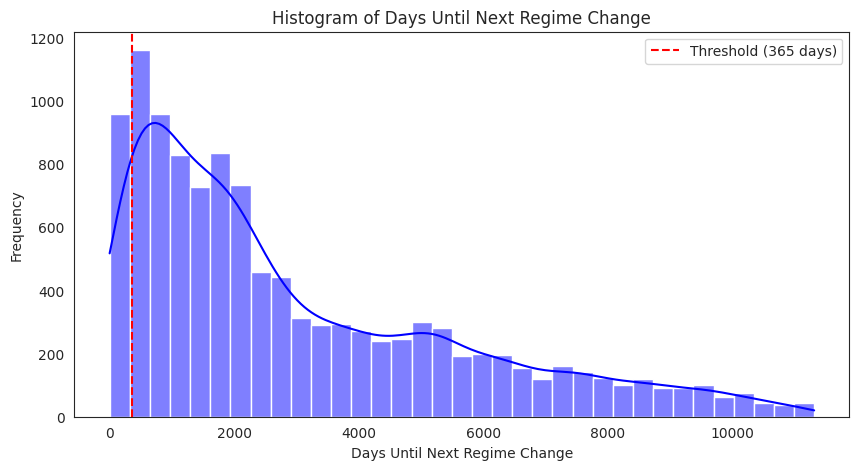

In [ ]:
days_until_next_regime_chg = data_['days_until_next_regime_chg']

# Create a histogram
plt.figure(figsize=(10, 5))
sns.histplot(days_until_next_regime_chg, kde=True, color='blue')
plt.axvline(x=365, color='red', linestyle='--', label='Threshold (365 days)')
plt.xlabel('Days Until Next Regime Change')
plt.ylabel('Frequency')
plt.title('Histogram of Days Until Next Regime Change')
plt.legend()
plt.savefig('/content/drive/MyDrive/DATA/RESULTS/days_regime_change_dist.png')
plt.show()

In [ ]:
def sort_by_mse(X_test, exp_model):
    X_pred_h = exp_model.autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - X_pred_h, 2), axis=1)
    record = X_test.iloc[np.argsort(mse)]
    return record, X_pred_h
x_explain, X_pred_h = sort_by_mse(X_test, exp_model)

# Assuming X_train and data are already defined and have the 'country' column
train_index = list(X_train.index)
filtered_data = data_[data_.index.isin(train_index)]

# Join the 'country' column from filtered_data to X_train
X_train_with_country = X_train.join(filtered_data['country'])


from google.colab import data_table
data_table.enable_dataframe_formatter()



# anomalies = data_[["country",
#             "startdated",
#             "duration_days",
#             "next_regime_chg_date",
#             "days_until_next_regime_chg",
#             "target", "sources"]].iloc[list(exp_model.get_top_anomaly_to_explain(x_explain))]

# top_records_to_explain = [4491, 9894, 9971, 7295, 2760]
# top_records_to_explain = [9970, 4949, 10251, 2739, 11068, 3280]
# top_records_to_explain = [10192]
top_records_to_explain = [10251]
anomalies = data_[["country",
            "startdated",
            "duration_days",
            "next_regime_chg_date",
            "days_until_next_regime_chg",
            "target", "sources"]].iloc[top_records_to_explain]


anomalies.to_csv('/content/drive/MyDrive/DATA/RESULTS/anomalies.csv')

114/114 [==============================] - 0s 2ms/step


In [ ]:
anomalies

,country,startdated,duration_days,next_regime_chg_date,days_until_next_regime_chg,target,sources
10251,Ukraine,28/03/2014,1,26/11/2014,243,1,"by trying to bolster ukraine, are nationalists..."


In [ ]:
    # record_country = anomalies[anomalies.index == record_idx]['country'].values[0]
    # background_set = (X_train_with_country[X_train_with_country.country == record_country]).drop(['country'], axis = 1)

In [ ]:
def get_highest_contributing_features(highest_contributing_features, idx_explained_feature, condition, record_to_explain):
    result = []
    for idx, row in highest_contributing_features.iterrows():
        if idx[0] == idx_explained_feature and condition(row[0]):
            actual_value = round(record_to_explain[idx[1]],2)
            result.append((idx[1], round(row[0], 4), actual_value))
    return result

def process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain):
    for idx_explained_feature in range(len(df_top_err)):
        set_contributing_features = []
        set_offsetting_features = []

        if predicted_value[df_top_err.index[idx_explained_feature]] > actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)

        elif predicted_value[df_top_err.index[idx_explained_feature]] < actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)

        if set_contributing_features or set_offsetting_features:
            feature_name = X.columns[df_top_err.index[idx_explained_feature]]
            actual_value_str = f"{round(float(actual_value[df_top_err.index[idx_explained_feature]]), 4)}"
            predicted_value_str = f"{round(float(predicted_value[df_top_err.index[idx_explained_feature]]), 4)}"
            base_value_str = f"{round(float(explainer.expected_value), 4)}"

            set_contributing_features.insert(0, (feature_name, 'contributing', actual_value_str, predicted_value_str, base_value_str))
            set_offsetting_features.insert(0, (feature_name, 'offsetting', actual_value_str, predicted_value_str, base_value_str))

            all_sets_contributing_features[record_idx].append(set_contributing_features)
            all_sets_offsetting_features[record_idx].append(set_offsetting_features)

all_sets_offsetting_features = {}
all_sets_contributing_features = {}

top_records_to_explain = [ukrain_eu[0], 10251, ukrain_eu[-1] ]


for record_idx in top_records_to_explain:
    record_to_explain = x_explain.loc[record_idx,]

    df_err, total_mse, predicted_value, actual_value = exp_model.get_errors_df_per_record(record_to_explain)
    num_of_features = exp_model.get_num_features_with_highest_reconstruction_error(total_mse * df_err.shape[0], df_err)

    df_top_err = df_err.head(num_of_features)

    if 36 in df_top_err.index:
        df_top_err = df_top_err.drop(36)
        df_top_err = df_top_err.append(df_err.loc[36])
    else:
        index_36_row = df_err.loc[36]
        df_top_err = df_top_err.append(index_36_row)
        df_top_err = df_top_err.iloc[1:]

    all_sets_offsetting_features[record_idx] = []
    all_sets_contributing_features[record_idx] = []
    shap_values_all_features = [[] for _ in range(num_of_features)]

    background_set = shap.kmeans(X_train, 200)
    for i in range(num_of_features):
        exp_model.counter = df_top_err.index[i]
        explainer = shap.KernelExplainer(exp_model.func_predict_feature, background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        shap_values_all_features[i] = shap_values

    shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=X.columns)
    highest_contributing_features = exp_model.get_highest_shap_values(shap_values_all_features)

    process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain)

shap_values_all_features.to_csv('/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features.csv')

13425/13425 [==============================] - 26s 2ms/step


In [ ]:
df_top_err

,col_name,err
44,log_past_12mo_protests,0.206765
36,xconst,0.629668


In [ ]:
def inverse_minmax(normalized_value, min_val = -2 , max_val = 7):
    return (normalized_value * (max_val - min_val)) + min_val

inverse_minmax(0.0501)

-1.5491000000000001

# Ukraine

Dropdown(description='Select Feature:', index=3, layout=Layout(width='max-content'), options=('All', 'legelec'…

Button(description='Update Plot', layout=Layout(height='40px', width='max-content'), style=ButtonStyle())

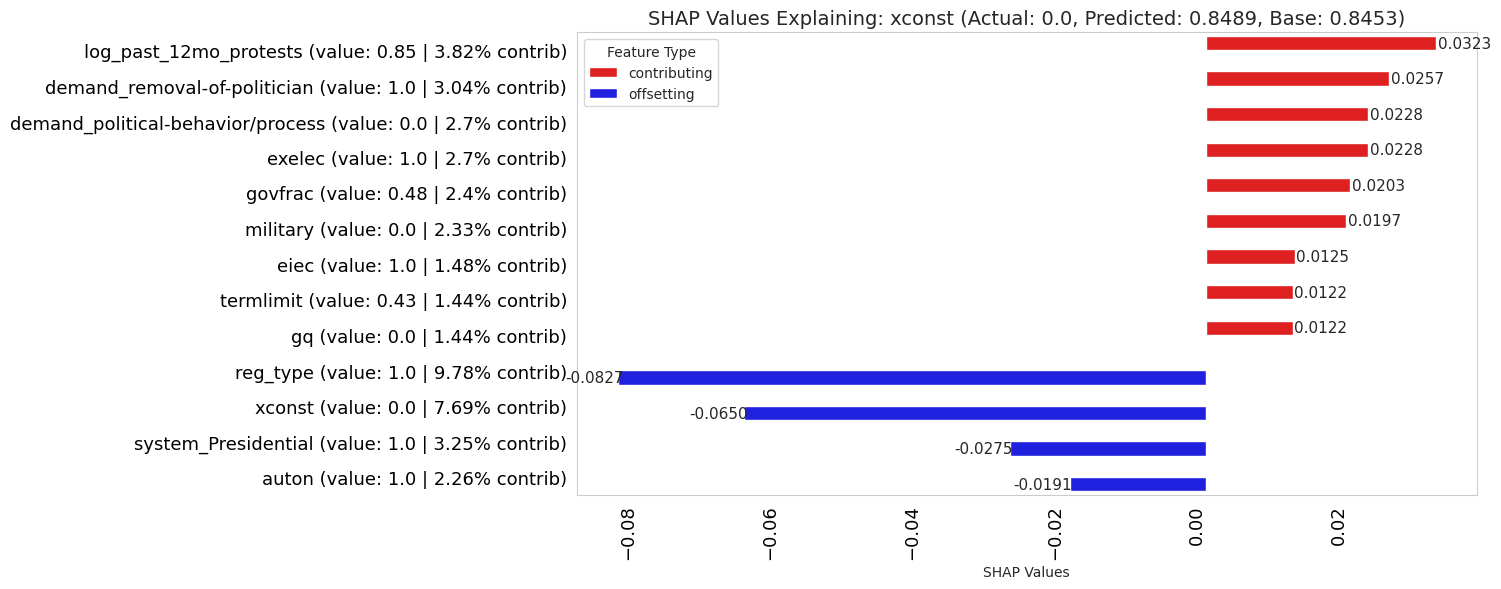

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a record index to investigate
record_idx_to_investigate = top_records_to_explain[1]

# Retrieve the contributing and offsetting features
contributing_features = all_sets_contributing_features[record_idx_to_investigate]
offsetting_features = all_sets_offsetting_features[record_idx_to_investigate]

# Combine contributing and offsetting features for easy access
features = contributing_features + offsetting_features

# Convert the nested list of features into a pandas DataFrame
data = []
for feature_set in features:
    for feature in feature_set[1:]:
        data.append([feature_set[0][0], feature_set[0][2], feature_set[0][3],feature_set[0][4],feature_set[0][1]] + list(feature))

df = pd.DataFrame(data, columns=["feature_name", "actual_value","predicted_value","base_value","feature_type", "x_data", "y_data", "record_value"])

# df.actual_value = df.actual_value.apply(lambda x: round(inverse_minmax(float(x)),2))
# df.predicted_value = df.predicted_value.apply(lambda x: round(inverse_minmax(float(x)),2))
# df.base_value = df.base_value.apply(lambda x: round(inverse_minmax(float(x)),2))
# df.y_data = df.y_data.apply(lambda x: round(inverse_minmax(float(x)),2))
# df['record_value'] = df['record_value'].apply(lambda x: round(inverse_minmax(abs(float(x))) * (-1 if x < 0 else 1),2))

# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} ({row['record_value']})", axis=1)
df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | {round((np.abs(row['y_data'])/np.abs(float(row['base_value'])-float(row['actual_value'])))*100,2)}% contrib)", axis=1)
# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | contr/offset {(np.abs(row['y_data'])/np.sum(np.abs(df[df.feature_name == 'xconst']['y_data'])))*100}%)", axis=1)

df.to_csv('/content/drive/MyDrive/DATA/RESULTS/record_explanation.csv')

df = df[np.abs(df.y_data)>= 0.01]

# df['x_tick_labels'] = df.apply(lambda row: f"{row['feature_name']} (Actual: {row['actual_value']}, Predicted: {row['predicted_value']}, Value: {row['x_data']} ({row['record_value']}))", axis=1)

def plot_shap_values(selected_feature="All"):
    if selected_feature == "All":
        filtered_df = df
    else:
        filtered_df = df[df["feature_name"] == selected_feature]

    plt.figure(figsize=(15,6))
    sns.set_style("whitegrid")
    ax = sns.barplot(data=filtered_df, x='y_data', y='x_tick_labels', hue='feature_type', palette=['red', 'blue'], ci=0, orient='h')

    # Update the title to include the feature name, actual value, and predicted value
    if selected_feature != "All":
        actual_value = filtered_df["actual_value"].iloc[0]
        predicted_value = filtered_df["predicted_value"].iloc[0]
        base_value = filtered_df["base_value"].iloc[0]
        title = f"SHAP Values Explaining: {selected_feature} (Actual: {actual_value}, Predicted: {predicted_value}, Base: {base_value})"
    else:
        title = "SHAP Values for Top Error Features"

    ax.set(title=title, xlabel='SHAP Values', ylabel='')
    ax.title.set_fontsize(14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13,  color='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13,  color='black')

    for p in ax.patches:
        if p.get_width() >= 0:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=11)
        else:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 0.99, p.get_y() + p.get_height() / 2), ha='right', va='center', fontsize=11)

    plt.xticks(rotation=90, ha='right')
    plt.legend(title="Feature Type")
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{selected_feature}.png')
    plt.show()

# Create a dropdown menu to select the feature
feature_dropdown = widgets.Dropdown(
    options=["All"] + list(df["feature_name"].unique()),
    description="Select Feature:",
    layout={'width': 'max-content'},  # Adjust the layout width
    style={'description_width': 'initial', 'font_size': 14}  # Increase font size for the dropdown
)

def on_button_click(_):
    clear_output(wait=True)
    display(feature_dropdown, button)
    plot_shap_values(feature_dropdown.value)

button = widgets.Button(description="Update Plot", layout={'width': 'max-content', 'height': '40px'}, style={'font_size': 14})
button.on_click(on_button_click)

display(feature_dropdown, button)

In [ ]:
def inverse_minmax(normalized_value, min_val = -2, max_val = 7):
    return (normalized_value * (max_val - min_val)) + min_val

round(inverse_minmax(1),0)

7

# Tunisia

In [ ]:
def get_highest_contributing_features(highest_contributing_features, idx_explained_feature, condition, record_to_explain):
    result = []
    for idx, row in highest_contributing_features.iterrows():
        if idx[0] == idx_explained_feature and condition(row[0]):
            actual_value = round(record_to_explain[idx[1]],2)
            result.append((idx[1], round(row[0], 4), actual_value))
    return result

def process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain):
    for idx_explained_feature in range(len(df_top_err)):
        set_contributing_features = []
        set_offsetting_features = []

        if predicted_value[df_top_err.index[idx_explained_feature]] > actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)

        elif predicted_value[df_top_err.index[idx_explained_feature]] < actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)

        if set_contributing_features or set_offsetting_features:
            feature_name = X.columns[df_top_err.index[idx_explained_feature]]
            actual_value_str = f"{round(float(actual_value[df_top_err.index[idx_explained_feature]]), 4)}"
            predicted_value_str = f"{round(float(predicted_value[df_top_err.index[idx_explained_feature]]), 4)}"
            base_value_str = f"{round(float(explainer.expected_value), 4)}"

            set_contributing_features.insert(0, (feature_name, 'contributing', actual_value_str, predicted_value_str, base_value_str))
            set_offsetting_features.insert(0, (feature_name, 'offsetting', actual_value_str, predicted_value_str, base_value_str))

            all_sets_contributing_features[record_idx].append(set_contributing_features)
            all_sets_offsetting_features[record_idx].append(set_offsetting_features)

all_sets_offsetting_features = {}
all_sets_contributing_features = {}

top_records_to_explain = [tinisia_as[0], 9974, tinisia_as[-1] ]


for record_idx in top_records_to_explain:
    record_to_explain = x_explain.loc[record_idx,]

    df_err, total_mse, predicted_value, actual_value = exp_model.get_errors_df_per_record(record_to_explain)
    num_of_features = exp_model.get_num_features_with_highest_reconstruction_error(total_mse * df_err.shape[0], df_err)

    df_top_err = df_err.head(num_of_features)

    if 36 in df_top_err.index:
        df_top_err = df_top_err.drop(36)
        df_top_err = df_top_err.append(df_err.loc[36])
    else:
        index_36_row = df_err.loc[36]
        df_top_err = df_top_err.append(index_36_row)
        df_top_err = df_top_err.iloc[1:]

    all_sets_offsetting_features[record_idx] = []
    all_sets_contributing_features[record_idx] = []
    shap_values_all_features = [[] for _ in range(num_of_features)]

    background_set = shap.kmeans(X_train, 50)
    for i in range(num_of_features):
        exp_model.counter = df_top_err.index[i]
        explainer = shap.KernelExplainer(exp_model.func_predict_feature, background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        shap_values_all_features[i] = shap_values

    shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=X.columns)
    highest_contributing_features = exp_model.get_highest_shap_values(shap_values_all_features)

    process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain)

shap_values_all_features.to_csv('/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features.csv')

3350/3350 [==============================] - 7s 2ms/step


Dropdown(description='Select Feature:', index=2, layout=Layout(width='max-content'), options=('All', 'system_P…

Button(description='Update Plot', layout=Layout(height='40px', width='max-content'), style=ButtonStyle())

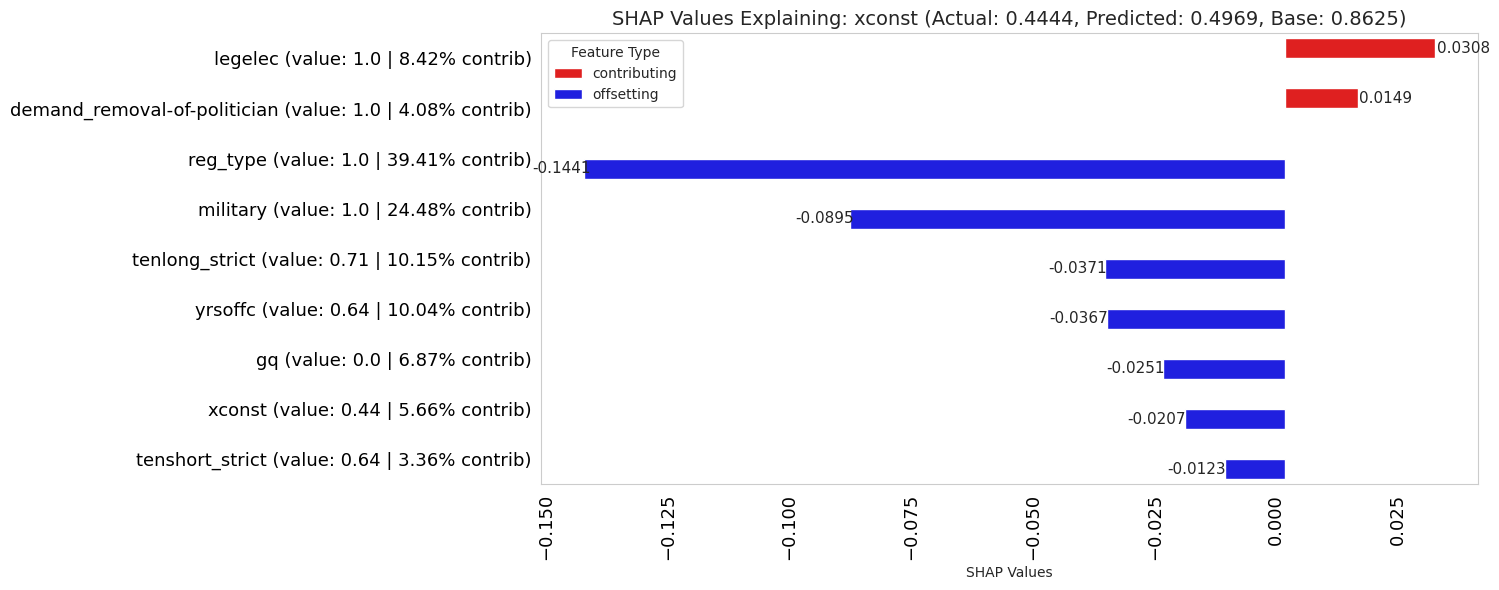

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a record index to investigate
record_idx_to_investigate = top_records_to_explain[-2]

# Retrieve the contributing and offsetting features
contributing_features = all_sets_contributing_features[record_idx_to_investigate]
offsetting_features = all_sets_offsetting_features[record_idx_to_investigate]

# Combine contributing and offsetting features for easy access
features = contributing_features + offsetting_features

# Convert the nested list of features into a pandas DataFrame
data = []
for feature_set in features:
    for feature in feature_set[1:]:
        data.append([feature_set[0][0], feature_set[0][2], feature_set[0][3],feature_set[0][4],feature_set[0][1]] + list(feature))

df = pd.DataFrame(data, columns=["feature_name", "actual_value","predicted_value","base_value","feature_type", "x_data", "y_data", "record_value"])

# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} ({row['record_value']})", axis=1)
df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | {round((np.abs(row['y_data'])/np.abs(float(row['base_value'])-float(row['predicted_value'])))*100,2)}% contrib)", axis=1)
# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | contr/offset {(np.abs(row['y_data'])/np.sum(np.abs(df[df.feature_name == 'xconst']['y_data'])))*100}%)", axis=1)

df.to_csv('/content/drive/MyDrive/DATA/RESULTS/record_explanation.csv')

df = df[np.abs(df.y_data)>= 0.01]

# df['x_tick_labels'] = df.apply(lambda row: f"{row['feature_name']} (Actual: {row['actual_value']}, Predicted: {row['predicted_value']}, Value: {row['x_data']} ({row['record_value']}))", axis=1)

def plot_shap_values(selected_feature="All"):
    if selected_feature == "All":
        filtered_df = df
    else:
        filtered_df = df[df["feature_name"] == selected_feature]

    plt.figure(figsize=(15,6))
    sns.set_style("whitegrid")
    ax = sns.barplot(data=filtered_df, x='y_data', y='x_tick_labels', hue='feature_type', palette=['red', 'blue'], ci=0, orient='h')

    # Update the title to include the feature name, actual value, and predicted value
    if selected_feature != "All":
        actual_value = filtered_df["actual_value"].iloc[0]
        predicted_value = filtered_df["predicted_value"].iloc[0]
        base_value = filtered_df["base_value"].iloc[0]
        title = f"SHAP Values Explaining: {selected_feature} (Actual: {actual_value}, Predicted: {predicted_value}, Base: {base_value})"
    else:
        title = "SHAP Values for Top Error Features"

    ax.set(title=title, xlabel='SHAP Values', ylabel='')
    ax.title.set_fontsize(14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13,  color='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13,  color='black')

    for p in ax.patches:
        if p.get_width() >= 0:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=11)
        else:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 0.99, p.get_y() + p.get_height() / 2), ha='right', va='center', fontsize=11)

    plt.xticks(rotation=90, ha='right')
    plt.legend(title="Feature Type")
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{selected_feature}.png')
    plt.show()

# Create a dropdown menu to select the feature
feature_dropdown = widgets.Dropdown(
    options=["All"] + list(df["feature_name"].unique()),
    description="Select Feature:",
    layout={'width': 'max-content'},  # Adjust the layout width
    style={'description_width': 'initial', 'font_size': 14}  # Increase font size for the dropdown
)

def on_button_click(_):
    clear_output(wait=True)
    display(feature_dropdown, button)
    plot_shap_values(feature_dropdown.value)

button = widgets.Button(description="Update Plot", layout={'width': 'max-content', 'height': '40px'}, style={'font_size': 14})
button.on_click(on_button_click)

display(feature_dropdown, button)

In [ ]:
round(inverse_minmax(0.8889),0)

6.0

# Yemen

In [ ]:
def get_highest_contributing_features(highest_contributing_features, idx_explained_feature, condition, record_to_explain):
    result = []
    for idx, row in highest_contributing_features.iterrows():
        if idx[0] == idx_explained_feature and condition(row[0]):
            actual_value = round(record_to_explain[idx[1]],2)
            result.append((idx[1], round(row[0], 4), actual_value))
    return result

def process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain):
    for idx_explained_feature in range(len(df_top_err)):
        set_contributing_features = []
        set_offsetting_features = []

        if predicted_value[df_top_err.index[idx_explained_feature]] > actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)

        elif predicted_value[df_top_err.index[idx_explained_feature]] < actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)

        if set_contributing_features or set_offsetting_features:
            feature_name = X.columns[df_top_err.index[idx_explained_feature]]
            actual_value_str = f"{round(float(actual_value[df_top_err.index[idx_explained_feature]]), 4)}"
            predicted_value_str = f"{round(float(predicted_value[df_top_err.index[idx_explained_feature]]), 4)}"
            base_value_str = f"{round(float(explainer.expected_value), 4)}"

            set_contributing_features.insert(0, (feature_name, 'contributing', actual_value_str, predicted_value_str, base_value_str))
            set_offsetting_features.insert(0, (feature_name, 'offsetting', actual_value_str, predicted_value_str, base_value_str))

            all_sets_contributing_features[record_idx].append(set_contributing_features)
            all_sets_offsetting_features[record_idx].append(set_offsetting_features)

all_sets_offsetting_features = {}
all_sets_contributing_features = {}

top_records_to_explain = [yemen_as[0], yemen_as[-3], yemen_as[-1] ]


for record_idx in top_records_to_explain:
    record_to_explain = x_explain.loc[record_idx,]

    df_err, total_mse, predicted_value, actual_value = exp_model.get_errors_df_per_record(record_to_explain)
    num_of_features = exp_model.get_num_features_with_highest_reconstruction_error(total_mse * df_err.shape[0], df_err)

    df_top_err = df_err.head(num_of_features)

    if 36 in df_top_err.index:
        df_top_err = df_top_err.drop(36)
        df_top_err = df_top_err.append(df_err.loc[36])
    else:
        index_36_row = df_err.loc[36]
        df_top_err = df_top_err.append(index_36_row)
        df_top_err = df_top_err.iloc[1:]

    all_sets_offsetting_features[record_idx] = []
    all_sets_contributing_features[record_idx] = []
    shap_values_all_features = [[] for _ in range(num_of_features)]

    background_set = shap.kmeans(X_train, 50)
    for i in range(num_of_features):
        exp_model.counter = df_top_err.index[i]
        explainer = shap.KernelExplainer(exp_model.func_predict_feature, background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        shap_values_all_features[i] = shap_values

    shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=X.columns)
    highest_contributing_features = exp_model.get_highest_shap_values(shap_values_all_features)

    process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain)

shap_values_all_features.to_csv('/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features.csv')

3347/3347 [==============================] - 5s 1ms/step


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a record index to investigate
record_idx_to_investigate = top_records_to_explain[-1]

# Retrieve the contributing and offsetting features
contributing_features = all_sets_contributing_features[record_idx_to_investigate]
offsetting_features = all_sets_offsetting_features[record_idx_to_investigate]

# Combine contributing and offsetting features for easy access
features = contributing_features + offsetting_features

# Convert the nested list of features into a pandas DataFrame
data = []
for feature_set in features:
    for feature in feature_set[1:]:
        data.append([feature_set[0][0], feature_set[0][2], feature_set[0][3],feature_set[0][4],feature_set[0][1]] + list(feature))

df = pd.DataFrame(data, columns=["feature_name", "actual_value","predicted_value","base_value","feature_type", "x_data", "y_data", "record_value"])

# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} ({row['record_value']})", axis=1)
df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | {round((np.abs(row['y_data'])/np.abs(float(row['base_value'])-float(row['predicted_value'])))*100,2)}% contrib)", axis=1)
# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | contr/offset {(np.abs(row['y_data'])/np.sum(np.abs(df[df.feature_name == 'xconst']['y_data'])))*100}%)", axis=1)

df.to_csv('/content/drive/MyDrive/DATA/RESULTS/record_explanation.csv')

df = df[np.abs(df.y_data)>= 0.01]

# df['x_tick_labels'] = df.apply(lambda row: f"{row['feature_name']} (Actual: {row['actual_value']}, Predicted: {row['predicted_value']}, Value: {row['x_data']} ({row['record_value']}))", axis=1)

def plot_shap_values(selected_feature="All"):
    if selected_feature == "All":
        filtered_df = df
    else:
        filtered_df = df[df["feature_name"] == selected_feature]

    plt.figure(figsize=(15,6))
    sns.set_style("whitegrid")
    ax = sns.barplot(data=filtered_df, x='y_data', y='x_tick_labels', hue='feature_type', palette=['red', 'blue'], ci=0, orient='h')

    # Update the title to include the feature name, actual value, and predicted value
    if selected_feature != "All":
        actual_value = filtered_df["actual_value"].iloc[0]
        predicted_value = filtered_df["predicted_value"].iloc[0]
        base_value = filtered_df["base_value"].iloc[0]
        title = f"SHAP Values Explaining: {selected_feature} (Actual: {actual_value}, Predicted: {predicted_value}, Base: {base_value})"
    else:
        title = "SHAP Values for Top Error Features"

    ax.set(title=title, xlabel='SHAP Values', ylabel='')
    ax.title.set_fontsize(14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13,  color='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13,  color='black')

    for p in ax.patches:
        if p.get_width() >= 0:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=11)
        else:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 0.99, p.get_y() + p.get_height() / 2), ha='right', va='center', fontsize=11)

    plt.xticks(rotation=90, ha='right')
    plt.legend(title="Feature Type")
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{selected_feature}.png')
    plt.show()

# Create a dropdown menu to select the feature
feature_dropdown = widgets.Dropdown(
    options=["All"] + list(df["feature_name"].unique()),
    description="Select Feature:",
    layout={'width': 'max-content'},  # Adjust the layout width
    style={'description_width': 'initial', 'font_size': 14}  # Increase font size for the dropdown
)

def on_button_click(_):
    clear_output(wait=True)
    display(feature_dropdown, button)
    plot_shap_values(feature_dropdown.value)

button = widgets.Button(description="Update Plot", layout={'width': 'max-content', 'height': '40px'}, style={'font_size': 14})
button.on_click(on_button_click)

display(feature_dropdown, button)

Dropdown(description='Select Feature:', layout=Layout(width='max-content'), options=('All', 'log_cum_participa…

Button(description='Update Plot', layout=Layout(height='40px', width='max-content'), style=ButtonStyle())

# Egypt

In [ ]:
def get_highest_contributing_features(highest_contributing_features, idx_explained_feature, condition, record_to_explain):
    result = []
    for idx, row in highest_contributing_features.iterrows():
        if idx[0] == idx_explained_feature and condition(row[0]):
            actual_value = round(record_to_explain[idx[1]],2)
            result.append((idx[1], round(row[0], 4), actual_value))
    return result

def process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain):
    for idx_explained_feature in range(len(df_top_err)):
        set_contributing_features = []
        set_offsetting_features = []

        if predicted_value[df_top_err.index[idx_explained_feature]] > actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)

        elif predicted_value[df_top_err.index[idx_explained_feature]] < actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)

        if set_contributing_features or set_offsetting_features:
            feature_name = X.columns[df_top_err.index[idx_explained_feature]]
            actual_value_str = f"{round(float(actual_value[df_top_err.index[idx_explained_feature]]), 4)}"
            predicted_value_str = f"{round(float(predicted_value[df_top_err.index[idx_explained_feature]]), 4)}"
            base_value_str = f"{round(float(explainer.expected_value), 4)}"

            set_contributing_features.insert(0, (feature_name, 'contributing', actual_value_str, predicted_value_str, base_value_str))
            set_offsetting_features.insert(0, (feature_name, 'offsetting', actual_value_str, predicted_value_str, base_value_str))

            all_sets_contributing_features[record_idx].append(set_contributing_features)
            all_sets_offsetting_features[record_idx].append(set_offsetting_features)

all_sets_offsetting_features = {}
all_sets_contributing_features = {}

top_records_to_explain = [egypt_as[0], egypt_as[-3], egypt_as[-1]]


for record_idx in top_records_to_explain:
    record_to_explain = x_explain.loc[record_idx,]

    df_err, total_mse, predicted_value, actual_value = exp_model.get_errors_df_per_record(record_to_explain)
    num_of_features = exp_model.get_num_features_with_highest_reconstruction_error(total_mse * df_err.shape[0], df_err)

    df_top_err = df_err.head(num_of_features)

    if 36 in df_top_err.index:
        df_top_err = df_top_err.drop(36)
        df_top_err = df_top_err.append(df_err.loc[36])
    else:
        index_36_row = df_err.loc[36]
        df_top_err = df_top_err.append(index_36_row)
        df_top_err = df_top_err.iloc[1:]

    all_sets_offsetting_features[record_idx] = []
    all_sets_contributing_features[record_idx] = []
    shap_values_all_features = [[] for _ in range(num_of_features)]

    background_set = shap.kmeans(X_train, 50)
    for i in range(num_of_features):
        exp_model.counter = df_top_err.index[i]
        explainer = shap.KernelExplainer(exp_model.func_predict_feature, background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        shap_values_all_features[i] = shap_values

    shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=X.columns)
    highest_contributing_features = exp_model.get_highest_shap_values(shap_values_all_features)

    process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain)

shap_values_all_features.to_csv('/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features.csv')

3347/3347 [==============================] - 5s 1ms/step


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a record index to investigate
record_idx_to_investigate = top_records_to_explain[1]

# Retrieve the contributing and offsetting features
contributing_features = all_sets_contributing_features[record_idx_to_investigate]
offsetting_features = all_sets_offsetting_features[record_idx_to_investigate]

# Combine contributing and offsetting features for easy access
features = contributing_features + offsetting_features

# Convert the nested list of features into a pandas DataFrame
data = []
for feature_set in features:
    for feature in feature_set[1:]:
        data.append([feature_set[0][0], feature_set[0][2], feature_set[0][3],feature_set[0][4],feature_set[0][1]] + list(feature))

df = pd.DataFrame(data, columns=["feature_name", "actual_value","predicted_value","base_value","feature_type", "x_data", "y_data", "record_value"])

# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} ({row['record_value']})", axis=1)
df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | {round((np.abs(row['y_data'])/np.abs(float(row['base_value'])-float(row['predicted_value'])))*100,2)}% contrib)", axis=1)
# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | contr/offset {(np.abs(row['y_data'])/np.sum(np.abs(df[df.feature_name == 'xconst']['y_data'])))*100}%)", axis=1)

df.to_csv('/content/drive/MyDrive/DATA/RESULTS/record_explanation.csv')

df = df[np.abs(df.y_data)>= 0.01]

# df['x_tick_labels'] = df.apply(lambda row: f"{row['feature_name']} (Actual: {row['actual_value']}, Predicted: {row['predicted_value']}, Value: {row['x_data']} ({row['record_value']}))", axis=1)

def plot_shap_values(selected_feature="All"):
    if selected_feature == "All":
        filtered_df = df
    else:
        filtered_df = df[df["feature_name"] == selected_feature]

    plt.figure(figsize=(15,6))
    sns.set_style("whitegrid")
    ax = sns.barplot(data=filtered_df, x='y_data', y='x_tick_labels', hue='feature_type', palette=['red', 'blue'], ci=0, orient='h')

    # Update the title to include the feature name, actual value, and predicted value
    if selected_feature != "All":
        actual_value = filtered_df["actual_value"].iloc[0]
        predicted_value = filtered_df["predicted_value"].iloc[0]
        base_value = filtered_df["base_value"].iloc[0]
        title = f"SHAP Values Explaining: {selected_feature} (Actual: {actual_value}, Predicted: {predicted_value}, Base: {base_value})"
    else:
        title = "SHAP Values for Top Error Features"

    ax.set(title=title, xlabel='SHAP Values', ylabel='')
    ax.title.set_fontsize(14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13,  color='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13,  color='black')

    for p in ax.patches:
        if p.get_width() >= 0:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=11)
        else:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 0.99, p.get_y() + p.get_height() / 2), ha='right', va='center', fontsize=11)

    plt.xticks(rotation=90, ha='right')
    plt.legend(title="Feature Type")
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{selected_feature}.png')
    plt.show()

# Create a dropdown menu to select the feature
feature_dropdown = widgets.Dropdown(
    options=["All"] + list(df["feature_name"].unique()),
    description="Select Feature:",
    layout={'width': 'max-content'},  # Adjust the layout width
    style={'description_width': 'initial', 'font_size': 14}  # Increase font size for the dropdown
)

def on_button_click(_):
    clear_output(wait=True)
    display(feature_dropdown, button)
    plot_shap_values(feature_dropdown.value)

button = widgets.Button(description="Update Plot", layout={'width': 'max-content', 'height': '40px'}, style={'font_size': 14})
button.on_click(on_button_click)

display(feature_dropdown, button)

Dropdown(description='Select Feature:', layout=Layout(width='max-content'), options=('All', 'system_Presidenti…

Button(description='Update Plot', layout=Layout(height='40px', width='max-content'), style=ButtonStyle())

# Earlier Protest Index

In [ ]:
def get_highest_contributing_features(highest_contributing_features, idx_explained_feature, condition, record_to_explain):
    result = []
    for idx, row in highest_contributing_features.iterrows():
        if idx[0] == idx_explained_feature and condition(row[0]):
            actual_value = round(record_to_explain[idx[1]],2)
            result.append((idx[1], round(row[0], 4), actual_value))
    return result

def process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain):
    for idx_explained_feature in range(len(df_top_err)):
        set_contributing_features = []
        set_offsetting_features = []

        if predicted_value[df_top_err.index[idx_explained_feature]] > actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)

        elif predicted_value[df_top_err.index[idx_explained_feature]] < actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)

        if set_contributing_features or set_offsetting_features:
            feature_name = X.columns[df_top_err.index[idx_explained_feature]]
            actual_value_str = f"{round(float(actual_value[df_top_err.index[idx_explained_feature]]), 4)}"
            predicted_value_str = f"{round(float(predicted_value[df_top_err.index[idx_explained_feature]]), 4)}"
            base_value_str = f"{round(float(explainer.expected_value), 4)}"

            set_contributing_features.insert(0, (feature_name, 'contributing', actual_value_str, predicted_value_str, base_value_str))
            set_offsetting_features.insert(0, (feature_name, 'offsetting', actual_value_str, predicted_value_str, base_value_str))

            all_sets_contributing_features[record_idx].append(set_contributing_features)
            all_sets_offsetting_features[record_idx].append(set_offsetting_features)

all_sets_offsetting_features = {}
all_sets_contributing_features = {}

top_records_to_explain = [ukrain_eu[0]]

for record_idx in top_records_to_explain:
    record_to_explain = x_explain.loc[record_idx,]

    df_err, total_mse, predicted_value, actual_value = exp_model.get_errors_df_per_record(record_to_explain)
    num_of_features = exp_model.get_num_features_with_highest_reconstruction_error(total_mse * df_err.shape[0], df_err)

    df_top_err = df_err.head(num_of_features)
    # df_top_err = df_err

    # desired_indices = [30, 36]
    # top_records = df_top_err.loc[desired_indices]
    # df_top_err = df_top_err.drop(desired_indices)
    # df_top_err = pd.concat([top_records, df_top_err], axis=0)

    all_sets_offsetting_features[record_idx] = []
    all_sets_contributing_features[record_idx] = []
    shap_values_all_features = [[] for _ in range(num_of_features)]

    background_set = shap.kmeans(X_train, 200)
    for i in range(num_of_features):
        exp_model.counter = df_top_err.index[i]
        explainer = shap.KernelExplainer(exp_model.func_predict_feature, background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        shap_values_all_features[i] = shap_values

    shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=X.columns)
    highest_contributing_features = exp_model.get_highest_shap_values(shap_values_all_features)

    process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain)

shap_values_all_features.to_csv('/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features.csv')

1/1 [==============================] - 0s 30ms/step


KeyError: ignored

Dropdown(description='Select Feature:', index=2, layout=Layout(width='max-content'), options=('All', 'govfrac'…

Button(description='Update Plot', layout=Layout(height='40px', width='max-content'), style=ButtonStyle())

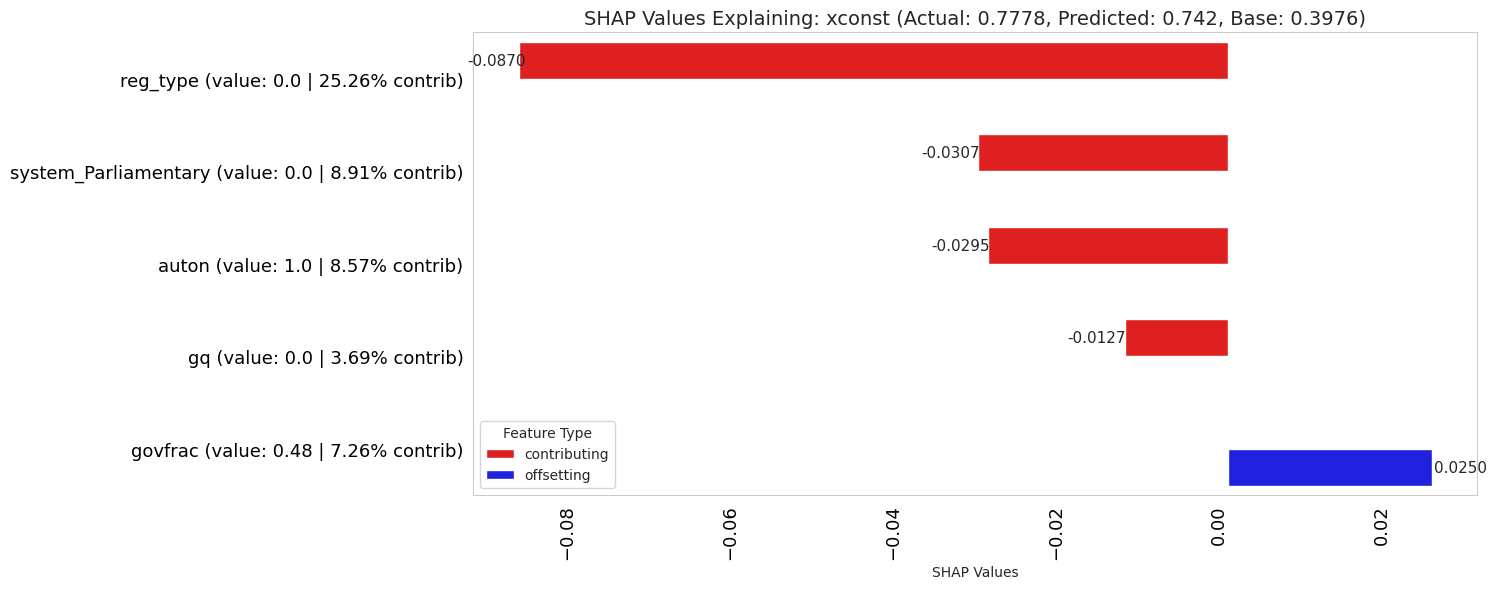

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a record index to investigate
record_idx_to_investigate = top_records_to_explain[0]

# Retrieve the contributing and offsetting features
contributing_features = all_sets_contributing_features[record_idx_to_investigate]
offsetting_features = all_sets_offsetting_features[record_idx_to_investigate]

# Combine contributing and offsetting features for easy access
features = contributing_features + offsetting_features

# Convert the nested list of features into a pandas DataFrame
data = []
for feature_set in features:
    for feature in feature_set[1:]:
        data.append([feature_set[0][0], feature_set[0][2], feature_set[0][3],feature_set[0][4],feature_set[0][1]] + list(feature))

df = pd.DataFrame(data, columns=["feature_name", "actual_value","predicted_value","base_value","feature_type", "x_data", "y_data", "record_value"])


# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} ({row['record_value']})", axis=1)
df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | {round((np.abs(row['y_data'])/np.abs(float(row['base_value'])-float(row['predicted_value'])))*100,2)}% contrib)", axis=1)
# df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | contr/offset {(np.abs(row['y_data'])/np.sum(np.abs(df[df.feature_name == 'xconst']['y_data'])))*100}%)", axis=1)

df.to_csv('/content/drive/MyDrive/DATA/RESULTS/record_explanation.csv')

df = df[np.abs(df.y_data)>= 0.01]

# df['x_tick_labels'] = df.apply(lambda row: f"{row['feature_name']} (Actual: {row['actual_value']}, Predicted: {row['predicted_value']}, Value: {row['x_data']} ({row['record_value']}))", axis=1)

def plot_shap_values(selected_feature="All"):
    if selected_feature == "All":
        filtered_df = df
    else:
        filtered_df = df[df["feature_name"] == selected_feature]

    plt.figure(figsize=(15,6))
    sns.set_style("whitegrid")
    ax = sns.barplot(data=filtered_df, x='y_data', y='x_tick_labels', hue='feature_type', palette=['red', 'blue'], ci=0, orient='h')

    # Update the title to include the feature name, actual value, and predicted value
    if selected_feature != "All":
        actual_value = filtered_df["actual_value"].iloc[0]
        predicted_value = filtered_df["predicted_value"].iloc[0]
        base_value = filtered_df["base_value"].iloc[0]
        title = f"SHAP Values Explaining: {selected_feature} (Actual: {actual_value}, Predicted: {predicted_value}, Base: {base_value})"
    else:
        title = "SHAP Values for Top Error Features"

    ax.set(title=title, xlabel='SHAP Values', ylabel='')
    ax.title.set_fontsize(14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13,  color='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13,  color='black')

    for p in ax.patches:
        if p.get_width() >= 0:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=11)
        else:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 0.99, p.get_y() + p.get_height() / 2), ha='right', va='center', fontsize=11)

    plt.xticks(rotation=90, ha='right')
    plt.legend(title="Feature Type")
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{selected_feature}.png')
    plt.show()

# Create a dropdown menu to select the feature
feature_dropdown = widgets.Dropdown(
    options=["All"] + list(df["feature_name"].unique()),
    description="Select Feature:",
    layout={'width': 'max-content'},  # Adjust the layout width
    style={'description_width': 'initial', 'font_size': 14}  # Increase font size for the dropdown
)

def on_button_click(_):
    clear_output(wait=True)
    display(feature_dropdown, button)
    plot_shap_values(feature_dropdown.value)

button = widgets.Button(description="Update Plot", layout={'width': 'max-content', 'height': '40px'}, style={'font_size': 14})
button.on_click(on_button_click)

display(feature_dropdown, button)

# Counter

In [ ]:
def modify_record(record, feature_name, new_value):
    modified_record = record.copy()
    modified_record[feature_name] = new_value
    return modified_record

def get_highest_contributing_features(highest_contributing_features, idx_explained_feature, condition, record_to_explain):
    result = []
    for idx, row in highest_contributing_features.iterrows():
        if idx[0] == idx_explained_feature and condition(row[0]):
            actual_value = round(record_to_explain[idx[1]],2)
            result.append((idx[1], round(row[0], 4), actual_value))
    return result

def process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain):
    for idx_explained_feature in range(len(df_top_err)):
        set_contributing_features = []
        set_offsetting_features = []

        if predicted_value[df_top_err.index[idx_explained_feature]] > actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)

        elif predicted_value[df_top_err.index[idx_explained_feature]] < actual_value[df_top_err.index[idx_explained_feature]]:
            set_contributing_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x < 0, record_to_explain)
            set_offsetting_features = get_highest_contributing_features(highest_contributing_features, idx_explained_feature, lambda x: x > 0, record_to_explain)

        if set_contributing_features or set_offsetting_features:
            feature_name = X.columns[df_top_err.index[idx_explained_feature]]
            actual_value_str = f"{round(float(actual_value[df_top_err.index[idx_explained_feature]]), 4)}"
            predicted_value_str = f"{round(float(predicted_value[df_top_err.index[idx_explained_feature]]), 4)}"
            base_value_str = f"{round(float(explainer.expected_value), 4)}"

            set_contributing_features.insert(0, (feature_name, 'contributing', actual_value_str, predicted_value_str, base_value_str))
            set_offsetting_features.insert(0, (feature_name, 'offsetting', actual_value_str, predicted_value_str, base_value_str))

            all_sets_contributing_features[record_idx].append(set_contributing_features)
            all_sets_offsetting_features[record_idx].append(set_offsetting_features)

all_sets_offsetting_features = {}
all_sets_contributing_features = {}


for record_idx in top_records_to_explain:
    record_to_explain = x_explain.loc[record_idx,]

    f_name = 'xconst'
    new_value = 1
    record_to_explain = modify_record(record_to_explain, f_name, new_value)

    # f_name = 'log_past_12mo_protests'
    # new_value = 0.570885
    # record_to_explain = modify_record(record_to_explain, f_name, new_value)

    df_err, total_mse, predicted_value, actual_value = exp_model.get_errors_df_per_record(record_to_explain)
    desired_indices = [2,45,44, 36]
    top_records = df_err.loc[desired_indices]
    df_err = df_err.drop(desired_indices)
    df_err = pd.concat([top_records, df_err], axis=0)

    num_of_features = 4
    # exp_model.get_num_features_with_highest_reconstruction_error(total_mse * df_err.shape[0], df_err)

    df_top_err = df_err.head(num_of_features)
    all_sets_offsetting_features[record_idx] = []
    all_sets_contributing_features[record_idx] = []
    shap_values_all_features = [[] for _ in range(num_of_features)]

    background_set = shap.kmeans(X_train, 200)
    for i in range(num_of_features):
        exp_model.counter = df_top_err.index[i]
        explainer = shap.KernelExplainer(exp_model.func_predict_feature, background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        shap_values_all_features[i] = shap_values

    shap_values_all_features = pd.DataFrame(data=shap_values_all_features, columns=X.columns)
    highest_contributing_features = exp_model.get_highest_shap_values(shap_values_all_features)

    process_features(record_idx, df_top_err, highest_contributing_features, actual_value, predicted_value, explainer, all_sets_contributing_features, all_sets_offsetting_features, record_to_explain)

shap_values_all_features.to_csv('/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features_modified.csv')

13425/13425 [==============================] - 27s 2ms/step


Dropdown(description='Select Feature:', index=4, layout=Layout(width='max-content'), options=('All', 'demand_p…

Button(description='Update Plot', layout=Layout(height='40px', width='max-content'), style=ButtonStyle())

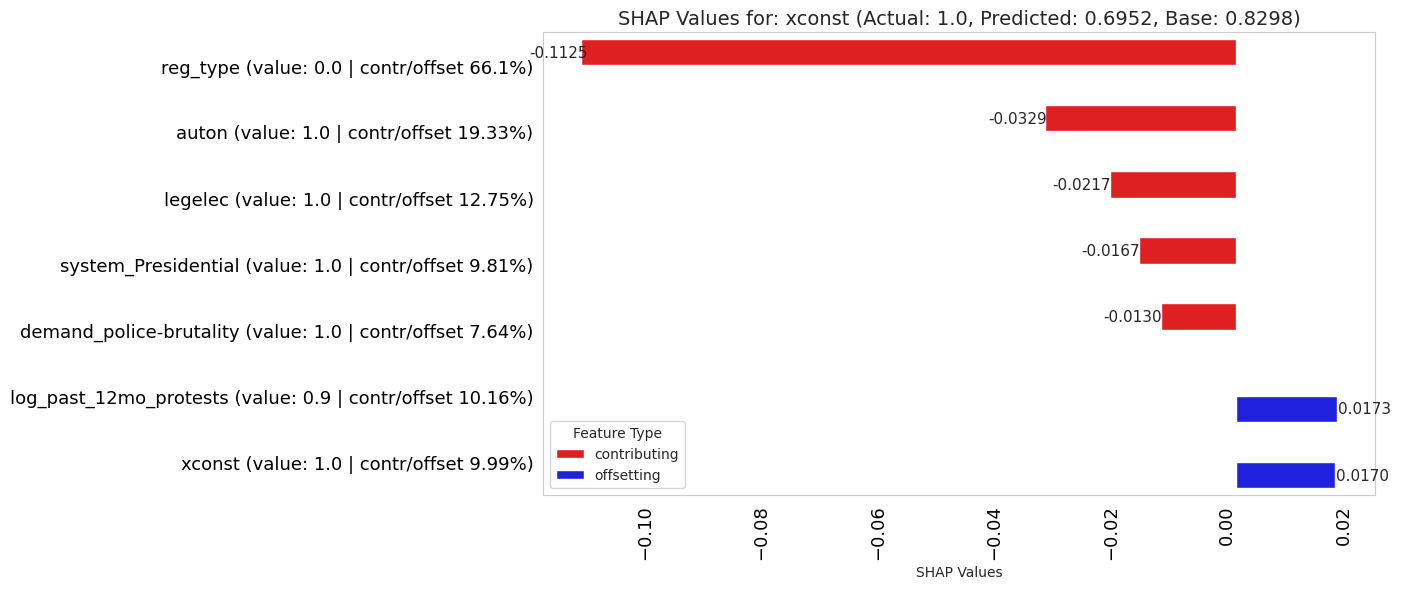

In [ ]:
# Choose a record index to investigate
record_idx_to_investigate = top_records_to_explain[0]

# Retrieve the contributing and offsetting features
contributing_features = all_sets_contributing_features[record_idx_to_investigate]
offsetting_features = all_sets_offsetting_features[record_idx_to_investigate]

# Combine contributing and offsetting features for easy access
features = contributing_features + offsetting_features

# Convert the nested list of features into a pandas DataFrame
data = []
for feature_set in features:
    for feature in feature_set[1:]:
        data.append([feature_set[0][0], feature_set[0][2], feature_set[0][3],feature_set[0][4],feature_set[0][1]] + list(feature))

df = pd.DataFrame(data, columns=["feature_name", "actual_value","predicted_value","base_value","feature_type", "x_data", "y_data", "record_value"])


df['x_tick_labels'] = df.apply(lambda row: f"{row['x_data']} (value: {row['record_value']} | contr/offset {round((np.abs(row['y_data'])/np.abs(float(row['actual_value'])-float(row['base_value'])))*100,2)}%)", axis=1)

df.to_csv('/content/drive/MyDrive/DATA/RESULTS/record_explanation_modified.csv')

df = df[np.abs(df.y_data)>= 0.01]

# df['x_tick_labels'] = df.apply(lambda row: f"{row['feature_name']} (Actual: {row['actual_value']}, Predicted: {row['predicted_value']}, Value: {row['x_data']} ({row['record_value']}))", axis=1)

def plot_shap_values(selected_feature="All"):
    if selected_feature == "All":
        filtered_df = df
    else:
        filtered_df = df[df["feature_name"] == selected_feature]

    plt.figure(figsize=(14,6))
    sns.set_style("whitegrid")
    ax = sns.barplot(data=filtered_df, x='y_data', y='x_tick_labels', hue='feature_type', palette=['red', 'blue'], ci=0, orient='h')

    # Update the title to include the feature name, actual value, and predicted value
    if selected_feature != "All":
        actual_value = filtered_df["actual_value"].iloc[0]
        predicted_value = filtered_df["predicted_value"].iloc[0]
        base_value = filtered_df["base_value"].iloc[0]
        title = f"SHAP Values for: {selected_feature} (Actual: {actual_value}, Predicted: {predicted_value}, Base: {base_value})"
    else:
        title = "SHAP Values for Top Error Features"

    ax.set(title=title, xlabel='SHAP Values', ylabel='')
    ax.title.set_fontsize(14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13,  color='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13,  color='black')

    for p in ax.patches:
        if p.get_width() >= 0:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 1.01, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=11)
        else:
            ax.annotate(f"{p.get_width():.4f}", (p.get_width() * 0.99, p.get_y() + p.get_height() / 2), ha='right', va='center', fontsize=11)


    plt.xticks(rotation=90, ha='right')
    plt.legend(title="Feature Type")
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/DATA/RESULTS/{selected_feature}_modified.png')
    plt.show()

# Create a dropdown menu to select the feature
feature_dropdown = widgets.Dropdown(
    options=["All"] + list(df["feature_name"].unique()),
    description="Select Feature:",
    layout={'width': 'max-content'},  # Adjust the layout width
    style={'description_width': 'initial', 'font_size': 14}  # Increase font size for the dropdown
)

def on_button_click(_):
    clear_output(wait=True)
    display(feature_dropdown, button)
    plot_shap_values(feature_dropdown.value)

button = widgets.Button(description="Update Plot", layout={'width': 'max-content', 'height': '40px'}, style={'font_size': 14})
button.on_click(on_button_click)

display(feature_dropdown, button)


In [ ]:
0.5643/(0.039*50)

0.2893846153846154

In [ ]:
df

,feature_name,actual_value,predicted_value,base_value,feature_type,x_data,y_data,record_value,x_tick_labels
0,xconst,1.0,0.7022,0.3837,contributing,reg_type,-0.0817,0.00,reg_type (value: 0.0 | contr/offset 13.26%)
1,xconst,1.0,0.7022,0.3837,contributing,auton,-0.0543,1.00,auton (value: 1.0 | contr/offset 8.81%)
2,xconst,1.0,0.7022,0.3837,contributing,exelec,-0.0292,1.00,exelec (value: 1.0 | contr/offset 4.74%)
3,xconst,1.0,0.7022,0.3837,contributing,gq,-0.0204,0.00,gq (value: 0.0 | contr/offset 3.31%)
4,xconst,1.0,0.7022,0.3837,contributing,demand_political-behavior/process,-0.0147,0.00,demand_political-behavior/process (value: 0.0 ...
5,xconst,1.0,0.7022,0.3837,contributing,system_Parliamentary,-0.0140,0.00,system_Parliamentary (value: 0.0 | contr/offse...
17,demand_police-brutality,1.0,0.5382,0.3837,contributing,system_Presidential,-0.0666,1.00,system_Presidential (value: 1.0 | contr/offset...
18,demand_police-brutality,1.0,0.5382,0.3837,contributing,system_Parliamentary,-0.0364,0.00,system_Parliamentary (value: 0.0 | contr/offse...
19,demand_police-brutality,1.0,0.5382,0.3837,contributing,log_cum_participants,-0.0247,0.80,log_cum_participants (value: 0.8 | contr/offse...
20,demand_police-brutality,1.0,0.5382,0.3837,contributing,oppvote,-0.0237,0.44,oppvote (value: 0.44 | contr/offset 3.85%)


In [ ]:
offset_df = pd.DataFrame.from_dict(all_sets_offsetting_features, orient='index')
offset_df = offset_df.apply(lambda x: pd.Series(x.values), axis=1).T;
offset_df.to_csv('/content/drive/MyDrive/DATA/RESULTS/offset.csv')
display(offset_df)

,10270
0,"[(xconst, offsetting, 1.0, 0.7022, 0.3837), (l..."
1,"[(demand_police-brutality, offsetting, 1.0, 0...."
2,"[(numvote, offsetting, 0.4488, 0.2851, 0.3837)..."
3,"[(log_past_12mo_protests, offsetting, 0.5709, ..."


In [ ]:
contib_df = pd.DataFrame.from_dict(all_sets_contributing_features, orient='index')
contib_df = contib_df.apply(lambda x: pd.Series(x.values), axis=1).T
contib_df.to_csv('/content/drive/MyDrive/DATA/RESULTS/contrib.csv')
contib_df

,10270
0,"[(xconst, contributing, 1.0, 0.7022, 0.3837), ..."
1,"[(demand_police-brutality, contributing, 1.0, ..."
2,"[(numvote, contributing, 0.4488, 0.2851, 0.383..."
3,"[(log_past_12mo_protests, contributing, 0.5709..."


### Distribution

243/243 [==============================] - 0s 2ms/step


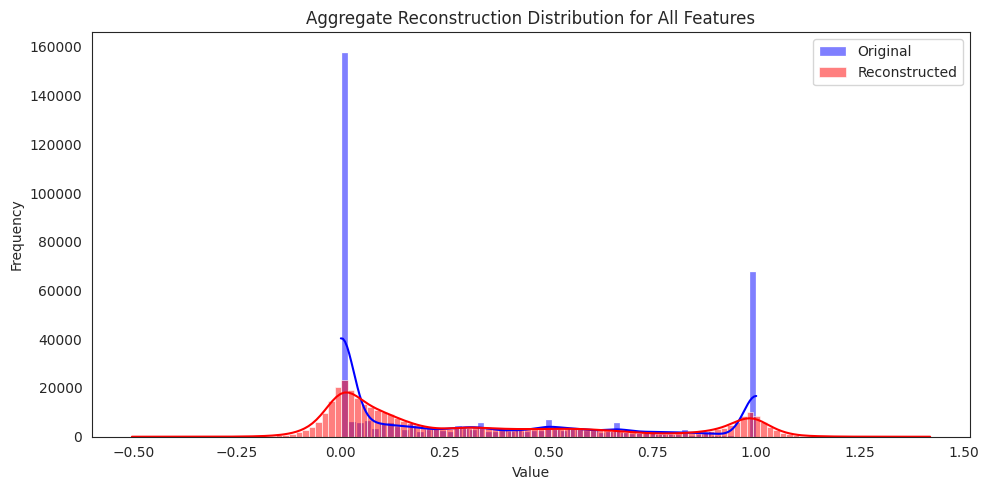

In [ ]:
reconstructed_X_test = exp_model.autoencoder.predict(X_test)
reconstructed_X_train = exp_model.autoencoder.predict(X_train)

reconstructed_X_train = pd.DataFrame(reconstructed_X_train, columns=X_train.columns)
reconstructed_X_test = pd.DataFrame(reconstructed_X_test, columns=X_test.columns)

# Flatten the original and reconstructed data
original_values_train = X_train.values.flatten()
reconstructed_values_train = reconstructed_X_train.values.flatten()
reconstructed_values_test = reconstructed_X_test.values.flatten()

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the original values
sns.histplot(original_values_train, ax=ax, color='blue', kde=True, label='Original', alpha=0.5)

# Plot the reconstructed values
sns.histplot(reconstructed_values_train, ax=ax, color='red', kde=True, label='Reconstructed', alpha=0.5)

ax.set_title('Aggregate Reconstruction Distribution for All Features')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.legend()

ax.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
from ipywidgets import interact_manual
def plot_reconstruction_distribution(feature):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the original values
    sns.histplot(X_train[feature], ax=ax, color='blue', kde=True, label='Original', alpha=0.5)

    # Plot the reconstructed values
    sns.histplot(reconstructed_X_train[feature], ax=ax, color='red', kde=True, label='Reconstructed', alpha=0.5)

    ax.set_title(f'Reconstruction Distribution for {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(False)

    plt.tight_layout()
    plt.show()


feature_selector = widgets.Dropdown(options=X_train.columns, description='Feature:')
interact_manual(plot_reconstruction_distribution, feature=feature_selector)


interactive(children=(Dropdown(description='Feature:', options=('demand_labor-wage-dispute', 'demand_land-farm…

<function __main__.plot_reconstruction_distribution(feature)>

In [ ]:
from ipywidgets import interact_manual

def plot_reconstruction_distribution(feature):
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot the original values
    sns.histplot(X_test[feature], ax=ax, color='blue', kde=True, label='Original', alpha=0.5)

    # Plot the reconstructed values
    sns.histplot(reconstructed_X_test[feature], ax=ax, color='red', kde=True, label='Reconstructed', alpha=0.5)

    ax.set_title(f'Reconstruction Distribution for {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=20)
    ax.legend()

    plt.tight_layout()
    ax.grid(False)
    plt.show()


feature_selector = widgets.Dropdown(options=X_test.columns, description='Feature:')
interact_manual(plot_reconstruction_distribution, feature=feature_selector)


interactive(children=(Dropdown(description='Feature:', options=('demand_labor-wage-dispute', 'demand_land-farm…

<function __main__.plot_reconstruction_distribution(feature)>

## Save Results

In [ ]:
# # highest_contributing_features.to_csv("/content/drive/MyDrive/DATA/EX/highest_contributing_features.csv")
# shap_values_all_features.to_csv("/content/drive/MyDrive/DATA/RESULTS/shap_values_all_features_.csv")
# df_err.to_csv("/content/drive/MyDrive/DATA/RESULTS/df_err_.csv")

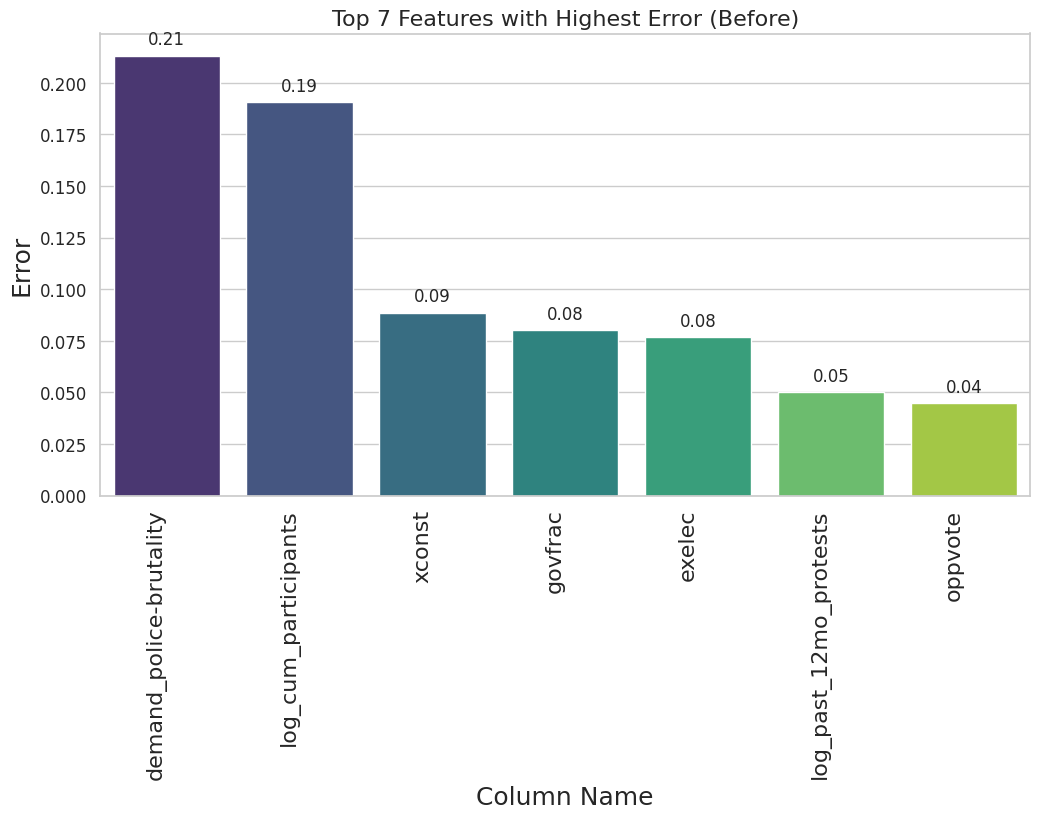

In [ ]:
# Assuming df_err is already defined, otherwise you can read it from a file using pd.read_csv() or similar methods.

# Sort the dataframe by 'err' in descending order and select the top 7 rows.
top_7_features = df_err.sort_values('err', ascending=False).head(7)

# Set the plot size.
plt.figure(figsize=(12, 6))

# Set the seaborn style for a more appealing plot.
sns.set(style="whitegrid")

# Create a bar plot using the 'col_name' as the x-axis and 'err' as the y-axis.
barplot = sns.barplot(x='col_name', y='err', data=top_7_features, palette="viridis")

# Set the title and axis labels.
plt.title('Top 7 Features with Highest Error (Before)', fontsize=16)
plt.xlabel('Column Name', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.xticks(rotation=90, ha='right', fontsize=16)
plt.yticks(fontsize=12)

# Add data labels to the bars.
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=12,
        xytext=(0, 5),
        textcoords="offset points",
    )

# Display the plot.
plt.show()

In [ ]:
df_err

,col_name,err
36,xconst,0.088660
2,demand_police-brutality,0.213294
25,numvote,0.026809
44,log_past_12mo_protests,0.050139
45,log_cum_participants,0.190670
30,govfrac,0.080356
19,exelec,0.076614
26,oppvote,0.044706
5,demand_removal-of-politician,0.029061
13,multpl,0.026147


In [ ]:
# # Sort the dataframe by 'err' in descending order and select the top 7 rows.
# top_7_features = df_err_hat.sort_values('err', ascending=False).head(7)

# # Set the plot size.
# plt.figure(figsize=(12, 6))

# # Set the seaborn style for a more appealing plot.
# sns.set(style="whitegrid")

# # Create a bar plot using the 'col_name' as the x-axis and 'err' as the y-axis.
# barplot = sns.barplot(x='col_name', y='err', data=top_7_features, palette="viridis")

# # Set the title and axis labels.
# plt.title('Top 7 Features with Highest Error (After)', fontsize=16)
# plt.xlabel('Column Name', fontsize=18)
# plt.ylabel('Error', fontsize=18)
# plt.xticks(rotation=90, ha='right', fontsize=16)
# plt.yticks(fontsize=12)

# # Add data labels to the bars.
# for p in barplot.patches:
#     barplot.annotate(
#         format(p.get_height(), ".2f"),
#         (p.get_x() + p.get_width() / 2, p.get_height()),
#         ha="center",
#         va="bottom",
#         fontsize=12,
#         xytext=(0, 5),
#         textcoords="offset points",
#     )

# # Display the plot.
# plt.show()

In [ ]:

# def plot_err_difference(df1, df2):
#     # Merge the two DataFrames based on the 'col_name' column, keeping the order from the first DataFrame
#     merged_df = df1.merge(df2, on='col_name', suffixes=('_1', '_2'))

#     # Calculate the difference of the 'err' column between the two DataFrames
#     merged_df['err_diff'] = merged_df['err_1'] - merged_df['err_2']

#     # Create a bar plot for the 'err_diff' column, using the 'col_name' column as labels
#     plt.figure(figsize=(10, 5))
#     plt.bar(merged_df['col_name'], merged_df['err_diff'])
#     plt.xlabel('Column Name')
#     plt.ylabel('Error Difference')
#     plt.title('Error Difference Between Two DataFrames')
#     plt.xticks(rotation=90)
#     plt.show()

# # Call the function to plot the difference
# plot_err_difference(df_err, df_err_hat)


In [ ]:
# Assuming you already have the following values
original_values = X_test
reconstructed_values = exp_model.autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed_values, 2), axis=1)

# Calculate feature-wise reconstruction errors
reconstruction_errors = np.power(original_values - reconstructed_values, 2)

# Calculate the top 10 features with the highest mean reconstruction error
feature_errors = pd.DataFrame(reconstruction_errors, columns=original_values.columns)
mean_feature_errors = feature_errors.mean(axis=0)
top_10_features = mean_feature_errors.nlargest(10).index

# Set the reconstruction error threshold
threshold = 0.02

# Select the top 10 features data
top_features_data = feature_errors[top_10_features]

# Melt the DataFrame to create a long format suitable for seaborn
top_features_melted = top_features_data.melt(var_name='Feature', value_name='Reconstruction Error')

# Plot the distribution of reconstruction errors for the top 10 features
fig, ax = plt.subplots(figsize=(20, 10))
sns.violinplot(ax=ax, data=top_features_melted, x='Feature', y='Reconstruction Error', inner="quartile", order=top_10_features)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()

# Add feature labels vertically and slightly to the left of the violins
for i, feature in enumerate(top_10_features):
    ax.text(i - 0.3, ax.get_ylim()[1] - 0.01, feature, ha='center', va='top', rotation='vertical', fontsize=18)

# Remove x-axis labels
ax.set_xticklabels([])


plt.grid(False)
plt.title("Top 10 Features with High Reconstruction Error")
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.set_title(ax.get_title(), fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
# # Assuming you already have the following values
# original_values = X_test
# reconstructed_values = exp_model.autoencoder.predict(X_test)
# mse = np.mean(np.power(X_test - reconstructed_values, 2), axis=1)

# # Calculate feature-wise reconstruction errors
# reconstruction_errors = np.power(original_values - reconstructed_values, 2)

# # Calculate the top 10 features with the highest mean reconstruction error
# feature_errors = pd.DataFrame(reconstruction_errors, columns=original_values.columns)
# mean_feature_errors = feature_errors.mean(axis=0)
# top_10_features = mean_feature_errors.nlargest(10)

# print(top_10_features)


In [ ]:
# mean_feature_errors.nlargest(10).index